# <center>CIC-Bell-DNS 2021 - Exploratory Data Analysis</center>

## 1. Introduction

### Dataset Overview

![CIC-Bell-DNS2021](https://www.unb.ca/cic/_assets/images/belldns2021.jpg)

The dataset being analyzed is part of a broader DNS tunneling detection study, specifically derived from the University of New Brunswick’s Canadian Institute for Cybersecurity (CIC) DNS-2021 dataset. This dataset is instrumental in identifying and classifying various types of DNS-based attacks, including malware, phishing, spam, and benign traffic.

<b>Dataset Generation Process: </b>

The dataset was generated through a multi-step process involving the collection, processing, and feature extraction of DNS traffic. Below is an overview of how the dataset was created:

1. **Domain Collection**: 
   - A large corpus of both benign and malicious domains was collected from various public sources, including Majestic Million, OpenPhish, PhishTank, DNS-BH, malwaredomainlist, and jwspamspy. 
   - The collected domains were categorized into four groups: benign, malware, spam, and phishing.

2. **DNS Packet Capture**:
   - HTTP requests were sent to each collected domain using a Python script, and the related network packets were captured using Wireshark.
   - The DNS packets that correspond to type A, AAAA, and CNAME query responses were retained, while others (e.g., queries and type SOA responses) were discarded.

3. **Feature Extraction**:
   - The DNS packets were processed to extract 32 discriminative features, categorized into lexical-based, DNS statistical-based, and third party-based (biographical) features.
   - The features were post-processed and transformed into continuous values for categorical features like the second-level domain (SLD), emails, and domain names.
   - The numerical features, such as TTL mean, TTL variance, and character distribution, were computed directly from the DNS traffic data.

4. **Final Dataset**:
   - After feature extraction and post-processing, the dataset was compiled into a CSV file containing both benign and malicious domain samples.

### Feature Engineering

As part of the dataset creation, various features were engineered to capture key characteristics of DNS traffic, aiding in the detection and classification of malicious domains. These features include:

- **Lexical Features**: Analyze the structure and content of domain names, such as length, character distribution, and obfuscation methods.
- **DNS Statistical Features**: Compute statistical information from DNS response packets, such as the average and variance of TTL values.
- **Third Party Features**: Extract biographical information from third-party APIs, such as domain age, registrar, and Alexa rank.

### Model Training and Validation
The dataset has been used to train various machine learning models, focusing on classifying domains not only as benign or malicious but also identifying the type of malicious activity (malware, spam, phishing). Notably, the k-Nearest Neighbors (k-NN) model achieved an F1-Score of:
- **94.8%** on balanced data (60/40% ratio)
- **99.4%** on imbalanced data (97/3% ratio)

### Accessing the Dataset
The dataset can be accessed from the University of New Brunswick's [CIC Datasets page](https://www.unb.ca/cic/datasets/dns-2021.html)

<b>The analysis involves four separate (preprocessed) CSV files:</b>

	•	processed_CSV_malware.csv
	•	processed_CSV_phishing.csv
	•	processed_CSV_spam.csv
	•	processed_CSV_benign
 
`the files has been processed in a seperate script on the repo at: scripts/data_preprocessing.py and then saved at data/processed`

 <b>Goals of the EDA:</b>
The primary goal of this Exploratory Data Analysis (EDA) is to understand the structure, relationships, and distributions of the DNS features across the different classes (malware, phishing, spam, benign). By combining these datasets, we aim to:

	•	Identify the most significant features that differentiate malicious traffic from benign traffic.
	•	Assess the distribution of DNS-related attributes across different types of traffic.
	•	Explore potential correlations between features and their impact on classifying DNS traffic.

<b>Hypotheses/Initial Questions:</b>

	1. Certain DNS attributes, will exhibit significant differences between malicious and benign traffic.
	2. The presence of specific patterns in DNS queries (character distribution) can be strong indicators of malicious activities.

`Initial Question: What are the distinguishing features in the DNS queries that allow for effective classification of traffic into malware, phishing, spam, or benign categories?`

## 2. Loading Data

#### Section 2.1: Import necessary libraries 


In [1]:
# Import necessary libraries
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from io import StringIO

# set pandas to display all columns
pd.set_option('display.max_columns', None)

# Set the path relative to the notebooks directory
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed')



In [2]:
# Add the eda_utils directory to the system path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'eda_utils'))

# import multiple functions from the eda_functions.py file
from eda_functions import (
    decide_fill_method,
    fill_numeric_columns, 
    align_data_types, 
    remove_outliers, 
    plot_feature_distribution, 
    analyze_categorical_feature,
    frequency_encode
)

#### Section 2.2: Load each CSV file into a separate DataFrame.


In [3]:
# Load the CSV files
df_malware = pd.read_csv(os.path.join(data_dir, 'processed_CSV_malware.csv'))
df_phishing = pd.read_csv(os.path.join(data_dir, 'processed_CSV_phishing.csv'))
df_spam = pd.read_csv(os.path.join(data_dir, 'processed_CSV_spam.csv'))
df_benign = pd.read_csv(os.path.join(data_dir, 'processed_CSV_benign.csv'), low_memory=False)

`all dataframes info's`

In [4]:
#  info for each DataFrame
dfs= [df_malware, df_phishing, df_spam, df_benign]
infos = []
for i, df in enumerate(dfs):
    buffer = StringIO()
    df.info(buf=buffer)
    infos.append(buffer.getvalue())

# combine the infos next to each other
combined_info = "\n".join(" | ".join(line) for line in zip(*map(str.splitlines, infos)))

# print the combined info
print(combined_info)

<class 'pandas.core.frame.DataFrame'> | <class 'pandas.core.frame.DataFrame'> | <class 'pandas.core.frame.DataFrame'> | <class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000 | RangeIndex: 5001 entries, 0 to 5000 | RangeIndex: 4337 entries, 0 to 4336 | RangeIndex: 500001 entries, 0 to 500000
Data columns (total 40 columns): | Data columns (total 40 columns): | Data columns (total 40 columns): | Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype   |  #   Column              Non-Null Count  Dtype   |  #   Column              Non-Null Count  Dtype   |  #   Column              Non-Null Count   Dtype  
---  ------              --------------  -----   | ---  ------              --------------  -----   | ---  ------              --------------  -----   | ---  ------              --------------   -----  
 0   Country             4055 non-null   object  |  0   Country             3578 non-null   object  |  0   Country             3490 non-null   o

`what are the common features between the dataframes?`

In [5]:
# find common features
common_columns = set(dfs[0].columns)

for df in dfs[1:]:
    common_columns.intersection_update(df.columns)

# convert to list 
common_columns = list(common_columns)

print("Common columns:", common_columns)

Common columns: ['IP', 'Registrant_Name', 'Domain_Age', 'dec_8', 'Organization', 'Alexa_Rank', 'dec_32', 'entropy', 'oc_8', '3gram', 'shortened', 'oc_32', 'Unnamed: 39', 'hex_32', '2gram', 'Domain_Name', 'ASN', 'Country.1', 'Domain', 'puny_coded', 'Country', '1gram', 'len', 'typos', 'Unnamed: 38', 'TTL', 'Emails', 'hex_8', 'Page_Rank', 'subdomain', 'obfuscate_at_sign', 'tld', 'State', 'longest_word', 'numeric_percentage', 'Creation_Date_Time', 'Name_Server_Count', 'Registrar', 'sld', 'char_distribution']


#### Section 2.3: Display the first few rows of each DataFrame to inspect the data.

In [6]:
print(df_malware.head(5))
print(df_phishing.head(5))
print(df_spam.head(5))
print(df_benign.head(5))

  Country       ASN    TTL             IP              Domain  oc_8  \
0      US   26347.0  14399  67.205.14.183  b'dicrophani.com.'     0   
1      US   46606.0  14399  70.40.220.126     b'dionneg.com.'     0   
2      US   16509.0   3599  15.164.151.80  b'vipprojects.cn.'     0   
3      US  395954.0    599  23.110.187.67         b'hhj3.cn.'     0   
4      US  395954.0    599  23.110.187.67         b'hhj3.cn.'     0   

  longest_word     Domain_Name  dec_32  subdomain          sld  \
0         hani  DICROPHANI.COM       0          0   dicrophani   
1          dio     DIONNEG.COM       0          0      dionneg   
2     projects  vipprojects.cn       0          0  vipprojects   
3           hh         hhj3.cn       0          0         hhj3   
4           hh         hhj3.cn       0          0         hhj3   

  Registrant_Name hex_32                 Domain_Age   entropy  \
0             NaN      0  4277 days 21:07:56.450015  2.963120   
1             NaN      0   4596 days 7:06:33.4

`It seems we have some null columns - we will deal with that later in the notebook`

## 3. Data Overview

#### Section 3.1: Check the shape (rows and columns) of each DataFrame

In [7]:
print("Shape of df_spam:", df_spam.shape)
print("Shape of df_phishing:", df_phishing.shape)
print("Shape of df_malware:", df_malware.shape)
print("Shape of df_benign:", df_benign.shape)

Shape of df_spam: (4337, 40)
Shape of df_phishing: (5001, 40)
Shape of df_malware: (5001, 40)
Shape of df_benign: (500001, 53)


`as been told in the article - the data is imbalanced - each of the malicious samples has 1% records vs the benign data`

#### Section 3.2: Summary statistics


In [8]:
print("Summary Statistics of df_spam:", df_spam.describe())
print("Summary Statistics of df_phishing:", df_phishing.describe())
print("Summary Statistics of df_malware:", df_malware.describe())
print("Summary Statistics of df_benign:", df_benign.describe())

Summary Statistics of df_spam:                  ASN           TTL   oc_32          len   puny_coded  \
count    3490.000000   4337.000000  4337.0  4337.000000  4337.000000   
mean    41856.764183   2257.754669     0.0    12.993313     0.051418   
std     67174.569662   4886.150062     0.0     4.979173     0.220874   
min       174.000000      1.000000     0.0     5.000000     0.000000   
25%     10782.000000    299.000000     0.0     9.000000     0.000000   
50%     20648.000000    599.000000     0.0    12.000000     0.000000   
75%     44066.000000   1799.000000     0.0    16.000000     0.000000   
max    395082.000000  46844.000000     0.0    32.000000     1.000000   

       shortened  dec_32       hex_32        hex_8   dec_8  obfuscate_at_sign  
count     4337.0  4337.0  4337.000000  4337.000000  4337.0             4337.0  
mean        -1.0     0.0    -0.286373    -0.011759     0.0                0.0  
std          0.0     0.0     0.607898     0.107813     0.0                0.0  


**General Observations:**
   - **ASN**: High variability across all datasets, with the benign set having the most entries.
   - **TTL**: Benign data has a wider range and higher maximum, indicating diverse and possibly longer-lived DNS records.

2. **Spam Dataset:**
   - High variability in `TTL`.
   - Uniform values in `oc_32`, `dec_32`, `hex_32`, `hex_8`, and `dec_8` suggest limited discriminative power.
   - Spam domains are generally shorter (`len` max: 32).

3. **Phishing Dataset:**
   - Higher `entropy` suggests more complex domain names.
   - Significant variation in `Alexa_Rank` and `len`.

4. **Malware Dataset:**
   - Lower `entropy` than phishing but still shows complexity.
   - Similar `Name_Server_Count` to phishing (median: 2).

5. **Benign Dataset:**
   - Wide `TTL` range, reflecting diverse DNS traffic.
   - Significant variability in `ASN`, indicating a wide distribution across ASNs.

### Key Takeaways:
- **Entropy** and **Name_Server_Count** are particularly useful for identifying phishing and malware.
- Obfuscation techniques are rarely used, making them less reliable for classification.
- High standard deviations in `TTL` and `ASN` highlight the diversity in domain characteristics, beneficial for model building.

#### Section 3.3: Data types and memory usage.

## 4. Data Cleaning

#### Section 4.1: Handle missing values (drop, fill, or impute)


In [9]:
# Function to drop columns with None or names starting with 'Unnamed'
def drop_none_unnamed_columns(df, df_name):
    before_columns = df.shape[1]  # Number of columns before dropping
    df = df.drop(columns=[col for col in df.columns if col is None or col.startswith('Unnamed')])
    after_columns = df.shape[1]  # Number of columns after dropping
    print(f"{df_name}: Columns before = {before_columns}, Columns after = {after_columns}")
    return df

# Apply this to all your DataFrames
df_spam = drop_none_unnamed_columns(df_spam, "df_spam")
df_phishing = drop_none_unnamed_columns(df_phishing, "df_phishing")
df_malware = drop_none_unnamed_columns(df_malware, "df_malware")
df_benign = drop_none_unnamed_columns(df_benign, "df_benign")

# Display the remaining columns to confirm the deletion
print("Remaining columns in df_spam:", df_spam.columns)
print("Remaining columns in df_phishing:", df_phishing.columns)
print("Remaining columns in df_malware:", df_malware.columns)
print("Remaining columns in df_benign:", df_benign.columns)

df_spam: Columns before = 40, Columns after = 38
df_phishing: Columns before = 40, Columns after = 38
df_malware: Columns before = 40, Columns after = 38
df_benign: Columns before = 53, Columns after = 38
Remaining columns in df_spam: Index(['Country', 'ASN', 'TTL', 'IP', 'Domain', 'sld', 'State', 'typos',
       'oc_32', 'len', 'puny_coded', 'shortened', 'dec_32', 'Registrant_Name',
       '3gram', 'Organization', 'Page_Rank', 'tld', 'Registrar', 'oc_8',
       'subdomain', 'Country.1', 'char_distribution', '1gram', 'longest_word',
       'Name_Server_Count', 'Alexa_Rank', 'hex_32', 'hex_8', 'dec_8',
       'obfuscate_at_sign', 'Creation_Date_Time', 'numeric_percentage',
       'Emails', '2gram', 'entropy', 'Domain_Age', 'Domain_Name'],
      dtype='object')
Remaining columns in df_phishing: Index(['Country', 'ASN', 'TTL', 'IP', 'Domain', 'Name_Server_Count',
       'Domain_Age', 'entropy', 'hex_8', 'numeric_percentage', '1gram',
       'typos', 'tld', 'char_distribution', 'subdomain'

In [10]:
df_benign.head()

,Country,ASN,TTL,IP,Domain,State,Registrant_Name,Country.1,Creation_Date_Time,hex_32,hex_8,Domain_Name,Alexa_Rank,subdomain,Organization,len,longest_word,oc_32,shortened,1gram,obfuscate_at_sign,entropy,Domain_Age,tld,dec_8,dec_32,Emails,numeric_percentage,puny_coded,typos,oc_8,3gram,char_distribution,2gram,Registrar,sld,Name_Server_Count,Page_Rank
0,US,15169.0,46,172.217.1.174,b'google.com.',CA,NaN,US,1997-09-15 04:00:00,0,0,"['GOOGLE.COM', 'google.com']",1.0,0,Google LLC,7,google,0,-1.0,"['g', 'o', 'o', 'g', 'l', 'e']",0,1.8348756474779464,8256 days 11:53:49.631067,com,0,0,"['abusecomplaints@markmonitor.com', 'whoisrequ...",0.0,0,"[('google.com', 100), ('google.com.br', 95)]",0,"['goo', 'oog', 'ogl', 'gle']","{'e': 1, 'o': 2, 'g': 2, 'l': 1}","['go', 'oo', 'og', 'gl', 'le']",MarkMonitor,Inc.,google,8.0
1,NaN,NaN,299,NaN,b'google.com.',CA,NaN,US,1997-09-15 04:00:00,0,0,"['GOOGLE.COM', 'google.com']",1.0,0,Google LLC,7,google,0,-1.0,"['g', 'o', 'o', 'g', 'l', 'e']",0,1.8348756474779464,8256 days 11:53:50.479085,com,0,0,"['abusecomplaints@markmonitor.com', 'whoisrequ...",0.0,0,"[('google.com', 100), ('google.com.br', 95)]",0,"['goo', 'oog', 'ogl', 'gle']","{'e': 1, 'o': 2, 'g': 2, 'l': 1}","['go', 'oo', 'og', 'gl', 'le']",MarkMonitor,Inc.,google,8.0
2,NaN,NaN,38,NaN,b'www.google.com.',NaN,NaN,NaN,1997-09-15 04:00:00,0,0,GOOGLE.COM,1.0,1,NaN,10,google,0,-1.0,"['g', 'o', 'o', 'g', 'l', 'e']",0,2.1142465351822795,8256 days 11:53:51.264191,com,0,0,abusecomplaints@markmonitor.com,0.0,0,"[('google.com', 100), ('google.com.br', 95)]",0,"['goo', 'oog', 'ogl', 'gle']","{'e': 1, 'o': 2, 'w': 3, 'l': 1, 'g': 2}","['go', 'oo', 'og', 'gl', 'le']",MarkMonitor Inc.,google,4.0,-1.0
3,US,15169.0,299,172.217.164.228,b'www.google.com.',NaN,NaN,NaN,NaN,0,0,NaN,NaN,1,NaN,10,google,0,-1.0,"['g', 'o', 'o', 'g', 'l', 'e']",0,2.1142465351822795,NaN,com,0,0,NaN,0.0,0,"[('google.com', 100), ('google.com.br', 95)]",0,"['goo', 'oog', 'ogl', 'gle']","{'e': 1, 'o': 2, 'w': 3, 'l': 1, 'g': 2}","['go', 'oo', 'og', 'gl', 'le']",NaN,google,NaN,NaN
4,NaN,NaN,96,NaN,b'facebook.com.',CA,NaN,US,1997-03-29 05:00:00,0,0,FACEBOOK.COM,4.0,0,Facebook,Inc.,9,facebook,0,-1.0,"['f', 'a', 'c', 'e', 'b', 'o', 'o', 'k']",0,2.5954888901709436,8426 days 10:53:52.505111,com,0,0,"['abusecomplaints@registrarsafe.com', 'domain@...",0.0,0,"[('facebook.com', 100), ('qq.com', 86)]",0,"['fac', 'ace', 'ceb', 'ebo', 'boo', 'ook']","{'e': 1, 'c': 1, 'o': 2, 'f': 1, 'k': 1, 'a':...","['fa', 'ac', 'ce', 'eb', 'bo', 'oo', 'ok']",RegistrarSafe,LLC,facebook


In [11]:
# calculate the % of missing values for a DataFrame
def missing_values_percentage(df):
    return df.isnull().mean() * 100

missing_spam = missing_values_percentage(df_spam).rename('df_spam')
missing_phishing = missing_values_percentage(df_phishing).rename('df_phishing')
missing_malware = missing_values_percentage(df_malware).rename('df_malware')
missing_benign = missing_values_percentage(df_benign).rename('df_benign')

missing_df = pd.concat([missing_spam, missing_phishing, missing_malware, missing_benign], axis=1)
missing_df = missing_df.sort_values(by=missing_df.columns.tolist(), ascending=False)
print(missing_df)

                      df_spam  df_phishing  df_malware  df_benign
Registrant_Name     99.538852    86.422715   98.540292  97.253605
Organization        57.574360    57.048590   54.189162  58.775482
State               55.752825    53.189362   46.810638  55.586489
Country.1           52.755361    45.530894   41.911618  48.180704
Emails              49.342864    41.071786   32.393521  34.043332
Registrar           42.656214    37.572486   26.114777  28.009144
Creation_Date_Time  42.195066    35.812837   23.515297  26.457547
Domain_Name         39.428176    32.473505   20.635873  19.344361
Page_Rank           27.484436    20.675865   11.697660  10.795178
Alexa_Rank          27.484436    20.675865   11.597680  10.769378
Name_Server_Count   27.484436    20.675865   11.417716  11.028178
Domain_Age          27.484436    20.675865   11.417716  10.766378
Country             19.529629    28.454309   18.916217  22.079156
ASN                 19.529629    28.454309   18.876225  22.067556
IP        

<b>a. Columns with High Missing Values (e.g., > 90%): may not provide much value and must be dropped</b>

In [12]:
# function to drop specific columns
def drop_columns(df, columns_to_drop):
    return df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# columns to drop
columns_to_drop = ['Registrant_Name']

# apply function
df_spam = drop_columns(df_spam, columns_to_drop)
df_phishing = drop_columns(df_phishing, columns_to_drop)
df_malware = drop_columns(df_malware, columns_to_drop)
df_benign = drop_columns(df_benign, columns_to_drop)


<b>b. Columns with Moderate Missing Values (40%-60%): Impute with 'Unknown'</b>

In [13]:
def fill_with_unknown(df_list, columns):

    for df in df_list:
        for col in columns:
            if col in df.columns:
                df[col] = df[col].fillna('unknown')
    
    return df_list

columns_to_fill = ['Creation_Date_Time', 'Registrar', 'Emails', 'State', 'Organization']
df_list = [df_spam, df_phishing, df_malware, df_benign]
cleaned_dfs = fill_with_unknown(df_list, columns_to_fill)

<b>c. Column Country - fill the null values with the value from Country.1 if exists - if not keep as 'unknown and then drop the column country .1 </b>

In [14]:
def clean_country_columns(df_list):
    for df in df_list:
        # Fill 'Country' with 'Country.1' values where 'Country' is null
        df['Country'] = df['Country'].fillna(df['Country.1'])
        
        # Label remaining nulls in 'Country' as 'unknown'
        df['Country'] = df['Country'].fillna('unknown')
        
        # Drop the 'Country.1' column
        df.drop(columns=['Country.1'], inplace=True)
    
    return df_list

# Example usage:
df_list = [df_spam, df_phishing, df_malware, df_benign]
cleaned_dfs = clean_country_columns(df_list)

<b>d. Columns with Lower Missing Values: </b>
* <b>Categorical -</b> fill the null values with 'unknown'
* <b>Numerical -</b> although those featurea are 3rd party features -  imputation should reflect the nature of the data. fill with Median or Mean (based on the distribution). 
* <b>special columns: ASN - </b>two identical IP addresses should have the same ASN. An ASN represents a network or group of networks, and all IPs within that network (or block) share the same ASN. So, it's safe to fill missing ASN values based on the IP address since the same IP should always map to the same ASN. see the explantion at:
[Cloudflare -  What is an autonomous system?](https://www.cloudflare.com/learning/network-layer/what-is-an-autonomous-system/)

In [15]:
# combine the dataframes and look for the ip values with null asn in other rows with the same IP where the ASN is not null 
def fill_asn_across_dataframes(df_list):
    #calculate % null before
    null_percentages_before = [df['ASN'].isnull().mean() * 100 for df in df_list]
    combined_df = pd.concat(df_list, ignore_index=True)
    
    #  mapping  IP to ASN for non-null ASN values across all dfs
    ip_to_asn_mapping = combined_df.dropna(subset=['ASN']).set_index('IP')['ASN'].to_dict()
    
    # fill missing ASN values in each df using the combined IP-to-ASN mapping
    for i, df in enumerate(df_list):
        df_list[i]['ASN'] = df.apply(lambda row: ip_to_asn_mapping.get(row['IP'], row['ASN']), axis=1)
    #calculate % null after
    null_percentages_after = [df['ASN'].isnull().mean() * 100 for df in df_list]
    # print before and after
    for i, df_name in enumerate(['df_spam', 'df_phishing', 'df_malware', 'df_benign']):
        print(f"{df_name} - % Null Before: {null_percentages_before[i]:.2f}%, % Null After: {null_percentages_after[i]:.2f}%")
    
    return df_list

df_list = [df_spam, df_phishing, df_malware, df_benign]
df_spam, df_phishing, df_malware, df_benign = fill_asn_across_dataframes(df_list)

df_spam - % Null Before: 19.53%, % Null After: 18.42%
df_phishing - % Null Before: 28.45%, % Null After: 28.45%
df_malware - % Null Before: 18.88%, % Null After: 18.88%
df_benign - % Null Before: 22.07%, % Null After: 22.00%


`It seems the function didn't worked - it's still goodd to keep it (assuming this will be part of a CI process)`

In [16]:
# for categorical features - fill with unknown
columns_to_fill = ['IP', 'Domain_Age', 'Domain_Name', 'ASN']
df_list = [df_spam, df_phishing, df_malware, df_benign]
cleaned_dfs = fill_with_unknown(df_list, columns_to_fill)

In [17]:
# convert the numeric features to numeric before procced
def convert_data_types(df_list):
    
    for df in df_list:
        if 'Alexa_Rank' in df.columns:
            df['Alexa_Rank'] = pd.to_numeric(df['Alexa_Rank'], errors='coerce').astype(float)
        if 'Page_Rank' in df.columns:
            df['Page_Rank'] = pd.to_numeric(df['Page_Rank'], errors='coerce').astype(float)
        if 'Name_Server_Count' in df.columns:
            df['Name_Server_Count'] = pd.to_numeric(df['Name_Server_Count'], errors='coerce').fillna(0).astype(int)
    return df_list

df_list = [df_spam, df_phishing, df_malware, df_benign]

df_list = convert_data_types(df_list)

In [18]:
# use the functions
numeric_columns_to_fill = ['Page_Rank', 'Alexa_Rank', 'Name_Server_Count']  
df_list = [df_spam, df_phishing, df_malware, df_benign]

# decide on the fill method  for each column based on skewness
fill_methods = decide_fill_method(df_list, numeric_columns_to_fill)

# Fill the numeric columns based on the decided method
cleaned_dfs = fill_numeric_columns(df_list, numeric_columns_to_fill, fill_methods)

In [19]:
# let's check what missing values have left now
missing_spam = missing_values_percentage(df_spam).rename('df_spam')
missing_phishing = missing_values_percentage(df_phishing).rename('df_phishing')
missing_malware = missing_values_percentage(df_malware).rename('df_malware')
missing_benign = missing_values_percentage(df_benign).rename('df_benign')

missing_df = pd.concat([missing_spam, missing_phishing, missing_malware, missing_benign], axis=1)
missing_df = missing_df.sort_values(by=missing_df.columns.tolist(), ascending=False)
print(missing_df)

                     df_spam  df_phishing  df_malware  df_benign
char_distribution   0.230574     0.000000    0.059988   0.000000
sld                 0.000000    12.217556    0.000000   0.032800
3gram               0.000000     1.259748    0.000000   0.000000
longest_word        0.000000     0.079984    0.000000   0.036600
dec_32              0.000000     0.059988    0.000000   0.010600
shortened           0.000000     0.019996    1.039792   0.265599
oc_32               0.000000     0.000000    0.359928   0.001400
2gram               0.000000     0.000000    0.179964   0.006800
hex_8               0.000000     0.000000    0.179964   0.002200
obfuscate_at_sign   0.000000     0.000000    0.019996   0.000000
numeric_percentage  0.000000     0.000000    0.000000   0.252799
len                 0.000000     0.000000    0.000000   0.142400
hex_32              0.000000     0.000000    0.000000   0.033000
1gram               0.000000     0.000000    0.000000   0.008400
puny_coded          0.000

#### Section 4.2: Correct data types if necessary.


`Now, even though some features still have missing values that need to be addressed, I will first align the data types of the same features across all dataframes before continuing.`

In [20]:
# dict to hold your DataFrames with their names
dataframes = {
    'df_spam': df_spam,
    'df_phishing': df_phishing,
    'df_malware': df_malware,
    'df_benign': df_benign
}

# get the mutual columns across all DataFrames
mutual_columns = set(dataframes['df_spam'].columns)
for df in dataframes.values():
    mutual_columns.intersection_update(df.columns)

#   set of mutual columns to a list
mutual_columns = list(mutual_columns)

# Create a df to store the mutual columns and their data types for each original dfs
dtype_df = pd.DataFrame()

for df_name, df in dataframes.items():
    dtype_series = df[mutual_columns].dtypes.rename(df_name)
    dtype_df = pd.concat([dtype_df, dtype_series], axis=1)

# set index as mutual columns
dtype_df.index.name = 'Column'

# display the DataFrame
print(dtype_df)

                    df_spam df_phishing df_malware df_benign
Column                                                      
IP                   object      object     object    object
Domain_Age           object      object     object    object
dec_8                 int64      object    float64    object
Organization         object      object     object    object
Alexa_Rank          float64     float64    float64   float64
dec_32                int64     float64      int64    object
entropy              object     float64    float64    object
oc_8                 object      object      int64    object
3gram                object      object     object    object
shortened             int64      object     object    object
oc_32                 int64     float64     object    object
hex_32              float64      object     object    object
2gram                object      object     object    object
Domain_Name          object      object     object    object
ASN                  obj

In [21]:
# Use the function to align the data types
df_list = [df_spam, df_phishing, df_malware, df_benign]
df_list = align_data_types(df_list)

`Now that we have aligned the data types across all dataframes, let's recheck the percentage of null values across the features.`

In [22]:
# let's check what missing values have left now
missing_spam = missing_values_percentage(df_spam).rename('df_spam')
missing_phishing = missing_values_percentage(df_phishing).rename('df_phishing')
missing_malware = missing_values_percentage(df_malware).rename('df_malware')
missing_benign = missing_values_percentage(df_benign).rename('df_benign')

missing_df = pd.concat([missing_spam, missing_phishing, missing_malware, missing_benign], axis=1)
missing_df = missing_df.sort_values(by=missing_df.columns.tolist(), ascending=False)
print(missing_df)

                      df_spam  df_phishing  df_malware  df_benign
entropy             38.736454     0.000000    0.000000   0.058800
numeric_percentage  37.560526     0.000000   37.512498  11.962576
char_distribution    0.230574     0.000000    0.059988   0.000000
hex_32               0.000000    40.191962    0.059988   0.164400
sld                  0.000000    12.217556    0.000000   0.032800
3gram                0.000000     1.259748    0.000000   0.000000
longest_word         0.000000     0.079984    0.000000   0.036600
oc_32                0.000000     0.000000    9.198160  11.698377
hex_8                0.000000     0.000000    0.199960   0.009800
2gram                0.000000     0.000000    0.179964   0.006800
1gram                0.000000     0.000000    0.000000   0.008400
Country              0.000000     0.000000    0.000000   0.000000
ASN                  0.000000     0.000000    0.000000   0.000000
TTL                  0.000000     0.000000    0.000000   0.000000
IP        

In [23]:
# decide_fill_method: fill_numeric_columns if float or int or fill_with_unknown if object 

# Numeric columns you want to fill based on skewness
numeric_columns_to_fill = ['entropy', 'numeric_percentage', 'hex_32', 'oc_32', 'hex_8']

# Categorical columns that need to be filled with 'unknown'
columns_to_fill_with_unknown = ['char_distribution', 'sld', '3gram', 'longest_word', '2gram', '1gram']

df_list = [df_spam, df_phishing, df_malware, df_benign]

# Decide on the fill method for numeric columns based on skewness
fill_methods = decide_fill_method(df_list, numeric_columns_to_fill)

# Fill the numeric columns based on the decided method
df_list = fill_numeric_columns(df_list, numeric_columns_to_fill, fill_methods)

# Fill categorical columns with 'unknown' using your existing function
df_list = fill_with_unknown(df_list, columns_to_fill_with_unknown)

/Users/royzalta/Documents/github-local/CIC-Bell-DNS-2021-ML/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


## 5. Data Merging

In [24]:
# Add the 'class' column to each df
df_spam['class'] = 'spam'
df_phishing['class'] = 'phishing'
df_malware['class'] = 'malware'
df_benign['class'] = 'benign'

# Concatenate all the dfs into one
df_combined = pd.concat([df_spam, df_phishing, df_malware, df_benign], ignore_index=True)

# show ffirat rows
df_combined.head()

,Country,ASN,TTL,IP,Domain,sld,State,typos,oc_32,len,puny_coded,shortened,dec_32,3gram,Organization,Page_Rank,tld,Registrar,oc_8,subdomain,char_distribution,1gram,longest_word,Name_Server_Count,Alexa_Rank,hex_32,hex_8,dec_8,obfuscate_at_sign,Creation_Date_Time,numeric_percentage,Emails,2gram,entropy,Domain_Age,Domain_Name,class
0,JP,2516.0,59,119.82.155.98,b'0900259.com.',0900259,Tokyo,"[('qq.com', 86), ('vk.com', 86)]",0.0,8,False,True,False,"['090', '900', '002', '025', '259']",Whois Privacy Protection Service by onamae.com,-1,com,GMO INTERNET,0,True,JP,"{'0': 3, '2': 1, '5': 1, '9': 2}","['0', '9', '0', '0', '2', '5', '9']",9,4.0,-1.0,0.0,0,0,0,0.0,53.846153846153854,"['abuse@gmo.jp', 'proxy@whoisprotectservice.com']",2.952882,1.7806390622295662,314 days 9:34:59.143460,spam
1,JP,2519.0,3599,116.91.115.130,b'koitera.net.',koitera,Tokyo,"[('php.net', 86), ('a8.net', 86)]",0.0,8,False,True,False,"['koi', 'oit', 'ite', 'ter', 'era']",Whois Privacy Protection Service by onamae.com,-1,net,GMO INTERNET,0,True,JP,"{'r': 1, 'i': 1, 't': 1, 'e': 1, 'a': 1, 'k':...","['k', 'o', 'i', 't', 'e', 'r', 'a']",0,8.0,-1.0,0.0,0,0,0,0.0,0.0,"['abuse@gmo.jp', 'proxy@whoisprotectservice.com']",2.952882,2.625,314 days 9:35:13.310505,spam
2,JP,2519.0,3599,116.91.115.130,b'koitera.com.',koitera,Tokyo,"[('qq.com', 86), ('vk.com', 86)]",0.0,8,False,True,False,"['koi', 'oit', 'ite', 'ter', 'era']",Whois Privacy Protection Service by onamae.com,-1,com,GMO INTERNET,0,True,JP,"{'r': 1, 'i': 1, 't': 1, 'e': 1, 'a': 1, 'k':...","['k', 'o', 'i', 't', 'e', 'r', 'a']",0,8.0,-1.0,0.0,0,0,0,0.0,0.0,"['abuse@gmo.jp', 'proxy@whoisprotectservice.com']",2.952882,2.625,1460 days 17:23:31.309635,spam
3,JP,2519.0,3599,116.91.115.130,b'pc.koitera.com.',koitera,Tokyo,"[('qq.com', 86), ('vk.com', 86)]",0.0,10,False,True,False,"['koi', 'oit', 'ite', 'ter', 'era']",Whois Privacy Protection Service by onamae.com,-1,com,GMO INTERNET,0,True,JP,"{'p': 1, 'i': 1, 'c': 1, 'r': 1, 't': 1, 'e':...","['k', 'o', 'i', 't', 'e', 'r', 'a']",0,8.0,-1.0,0.0,0,0,0,0.0,0.0,"['abuse@gmo.jp', 'proxy@whoisprotectservice.com']",2.952882,2.9897352853986265,1460 days 17:23:32.359161,spam
4,JP,2516.0,59,119.82.155.97,b'0901360.com.',0901360,Tokyo,"[('qq.com', 86), ('vk.com', 86)]",0.0,8,False,True,False,"['090', '901', '013', '136', '360']",Whois Privacy Protection Service by onamae.com,-1,com,GMO INTERNET,0,True,JP,"{'0': 3, '1': 1, '3': 1, '6': 1, '9': 1}","['0', '9', '0', '1', '3', '6', '0']",0,4.0,-1.0,0.0,0,0,0,0.0,53.846153846153854,"['abuse@gmo.jp', 'proxy@whoisprotectservice.com']",2.952882,2.0306390622295662,314 days 9:35:13.357891,spam


In [25]:
df_combined.groupby('class').size()

class
benign      500001
malware       5001
phishing      5001
spam          4337
dtype: int64

## 6. Exploratory Analysis

`In this part, after align our features on the same datatypes and treating null values - we'll be looking on the features coorelations and statistical trends across the different classes. `
#### Feature Descriptions

- **Country**: Country of the domain's registration or associated IP.
- **ASN**: Autonomous System Number, identifies the network managing the IP.
- **TTL**: Time-To-Live for DNS response caching (In seconds).
- **IP**: IP address associated with the domain.
- **Domain**: Full domain name queried.
- **sld**: Second-Level Domain, critical part of the domain name.
- **State**: State or region associated with the domain.
- **typos**: Indicates typosquatting in the domain name.
- **oc_32**: IP obfuscation in Decimal 32-bit format.
- **len**: Length of the domain including SLD and subdomains.
- **puny_coded**: Boolean indicating if the domain uses Punycode (encoding method used to represent Unicode characters in domain names).
- **shortened**: Boolean indicating if the domain is shortened.
- **dec_32**: Boolean indicating IP obfuscation in Decimal 32-bit format.
- **3gram**: Tri-gram sequences from the domain name.
- **Organization**: Organization associated with the domain registration.
- **Page_Rank**: Search engine ranking of the domain.
- **tld**: Top-Level Domain (e.g., .com, .net).
- **Registrar**: Entity that registered the domain.
- **oc_8**: IP obfuscation in Octal 8-bit format.
- **subdomain**: Boolean indicating presence of subdomains.
- **char_distribution**: Distribution of characters in the domain name.
- **1gram**: Uni-gram sequences from the domain name.
- **longest_word**: Longest meaningful word in the SLD.
- **Name_Server_Count**: Number of name servers associated with the domain.
- **Alexa_Rank**: Popularity rank of the domain by Alexa.
- **hex_32**: IP obfuscation in Hexadecimal 32-bit format.
- **hex_8**: IP obfuscation in Hexadecimal 8-bit format.
- **dec_8**: IP obfuscation in Decimal 8-bit format.
- **obfuscate_at_sign**: Count of obfuscation techniques applied.
- **Creation_Date_Time**: Date and time when the domain was created.
- **numeric_percentage**: Percentage of numeric characters in the domain.
- **Emails**: Emails associated with the domain registration.
- **2gram**: Bi-gram sequences from the domain name.
- **entropy**: Measure of randomness in character distribution.
- **Domain_Age**: Age of the domain.
- **Domain_Name**: Full name of the domain.
- **class**: Classification of the domain (`benign`, `spam`, `phishing`, `malware`).

#### Classes distribution:

In [26]:
total_rows = len(df_combined)
class_distribution = df_combined['class'].value_counts()
class_percentage = (class_distribution / total_rows) * 100

class_summary = pd.DataFrame({
    'Total Rows': class_distribution,
    'Percentage (%)': class_percentage
})

print(class_summary)

          Total Rows  Percentage (%)
class                               
benign        500001       97.212155
phishing        5001        0.972314
malware         5001        0.972314
spam            4337        0.843217


`Given the imbalanced nature of the combined dataset, where the benign class significantly outweighs the others, the strategedy will be to analyze the % of class total  distribution, not the total numbers`

` phishing, malware and Spam -  most  domains have a Page_Rank of -1, with a few having a rank of 0.
the benign class in contrast, has a much broader distribution of Page_Rank values, including some very high rankings (up to 4,001,999 that could be a data parsing error). This suggests that benign domains are generally more trusted or popular, as expected.`


### Section 6.1: Univariate Analysis

In [27]:
# keep a copy of df_combined as df_combined (for backup) and use df from now on
df = df_combined.copy()

`Quantile-Based Filtering: - For outliers,  remove  numerical values that are below or above certain 1%.`

In [28]:
# features to ignore (were not parsed well during preprocessing)
ignore_features = ['oc_32', 'oc_8', 'hex_32', 'hex_8', 'dec_8']

# apply remove outlier func to all numerical features except the ones to ignore
numerical_features = df_combined.select_dtypes(include=['float64', 'int64']).columns
for feature in numerical_features:
    if feature not in ignore_features:
        df_combined = remove_outliers(df_combined, feature)

Feature: TTL
Rows before removing outliers: 514340
Rows after removing outliers: 509261
Rows removed: 5079

Feature: len
Rows before removing outliers: 509261
Rows after removing outliers: 503197
Rows removed: 6064

Feature: Page_Rank
Rows before removing outliers: 503197
Rows after removing outliers: 498684
Rows removed: 4513

Feature: Name_Server_Count
Rows before removing outliers: 498684
Rows after removing outliers: 494878
Rows removed: 3806

Feature: Alexa_Rank
Rows before removing outliers: 494878
Rows after removing outliers: 489929
Rows removed: 4949

Feature: obfuscate_at_sign
Rows before removing outliers: 489929
Rows after removing outliers: 489098
Rows removed: 831

Feature: numeric_percentage
Rows before removing outliers: 489098
Rows after removing outliers: 484233
Rows removed: 4865

Feature: entropy
Rows before removing outliers: 484233
Rows after removing outliers: 479493
Rows removed: 4740



#### Distribution of key variables (histograms, box plots).


<b>Numeric Features:</b> Plot histograms and box plots for features such as Page_Rank, Alexa_Rank, TTL, Name_Server_Count, len, and entropy to understand their distributions and identify any outliers.

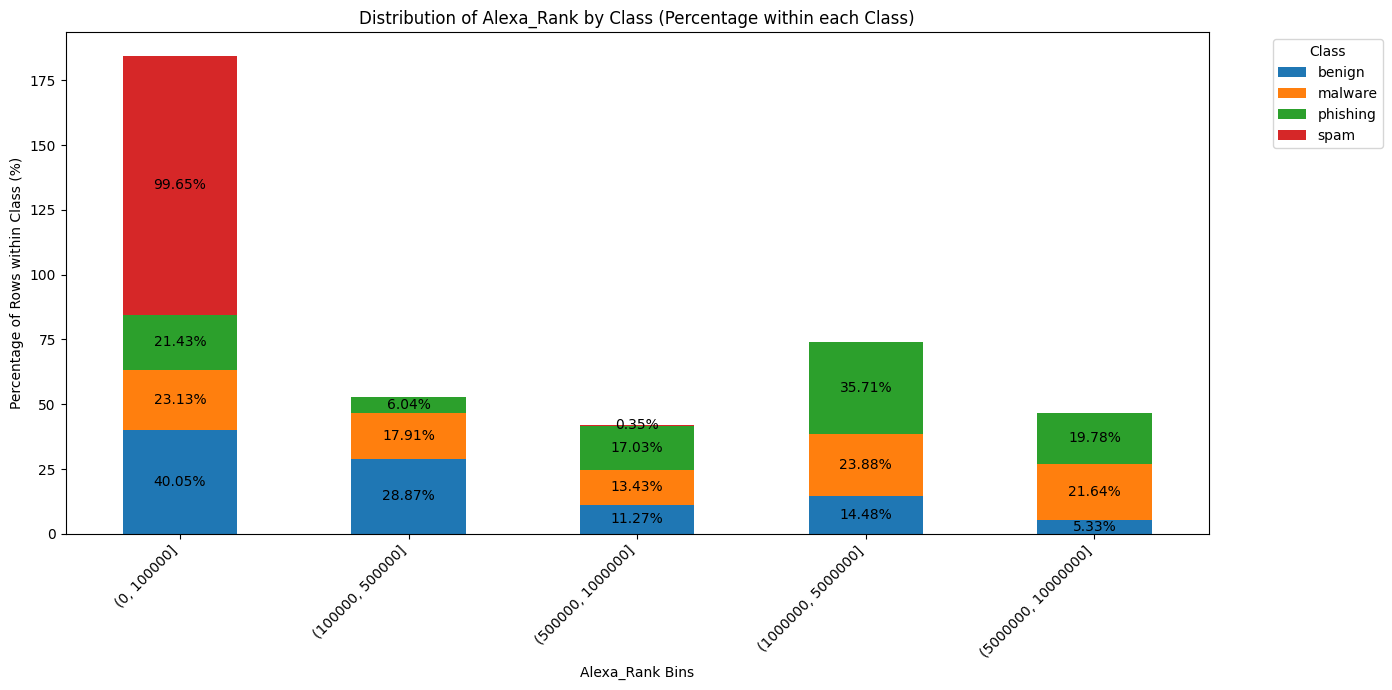

In [29]:
# alex rank:
plot_feature_distribution(df_combined, 'Alexa_Rank', bins=[0, 100000, 500000, 1000000, 5000000, 10000000])

In [30]:
Alexa_Rank_stats_by_class = df.groupby('class')['Alexa_Rank'].describe()

# Display the result
print(Alexa_Rank_stats_by_class)

             count           mean           std  min  25%      50%       75%  \
class                                                                          
benign    500001.0  726905.630675  1.810540e+06 -1.0 -1.0  82144.0  415482.0   
malware     5001.0  111446.978404  8.844254e+05 -1.0 -1.0      0.0       0.0   
phishing    5001.0  283034.144571  1.340702e+06 -1.0 -1.0      0.0       0.0   
spam        4337.0    2297.058105  4.674599e+04 -1.0 -1.0      2.0       4.0   

                 max  
class                 
benign    10918751.0  
malware   10899772.0  
phishing  10692543.0  
spam        974458.0  


`
Key Insight: Alexa Rank is a strong differentiator between benign and malicious domains, with lower ranks typically indicating benign activity and higher ranks associated with phishing and malware.
`

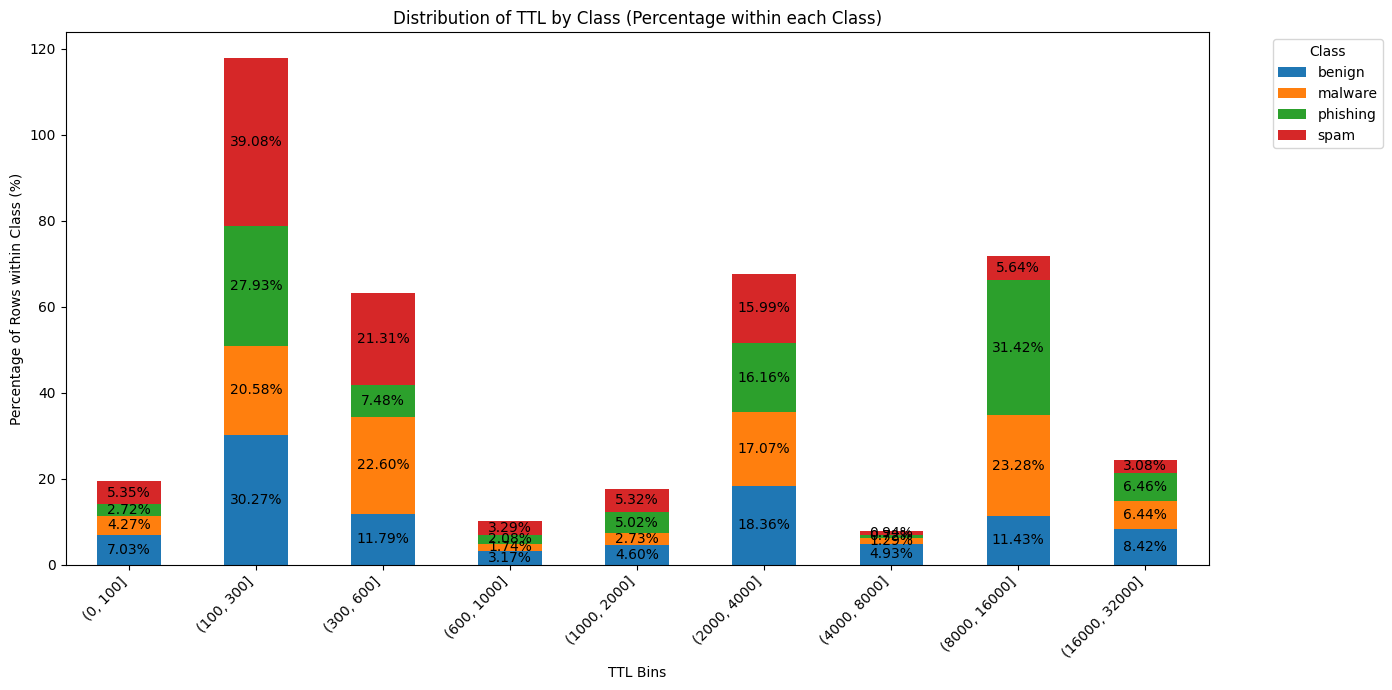

In [31]:
# TTL:
plot_feature_distribution(df_combined, 'TTL', 
                          bins=[0, 100, 300, 600, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000, 1024000])

In [32]:
TTL_stats_by_class = df.groupby('class')['TTL'].describe()

# Display the result
print(TTL_stats_by_class)

             count         mean           std  min    25%     50%      75%  \
class                                                                        
benign    500001.0  4584.705203   6599.213241  0.0  299.0   898.0   3599.0   
malware     5001.0  5274.558288  10285.763876  0.0  299.0   599.0  10799.0   
phishing    5001.0  5864.693661   6772.756116  0.0  299.0  2647.0  14388.0   
spam        4337.0  2257.754669   4886.150062  1.0  299.0   599.0   1799.0   

               max  
class               
benign     21599.0  
malware   397224.0  
phishing   46844.0  
spam       46844.0  


`
Benign URLS: The 100-300 TTL range is significant
`

`
Phishing URLs: 8000-16000 range spike.
`

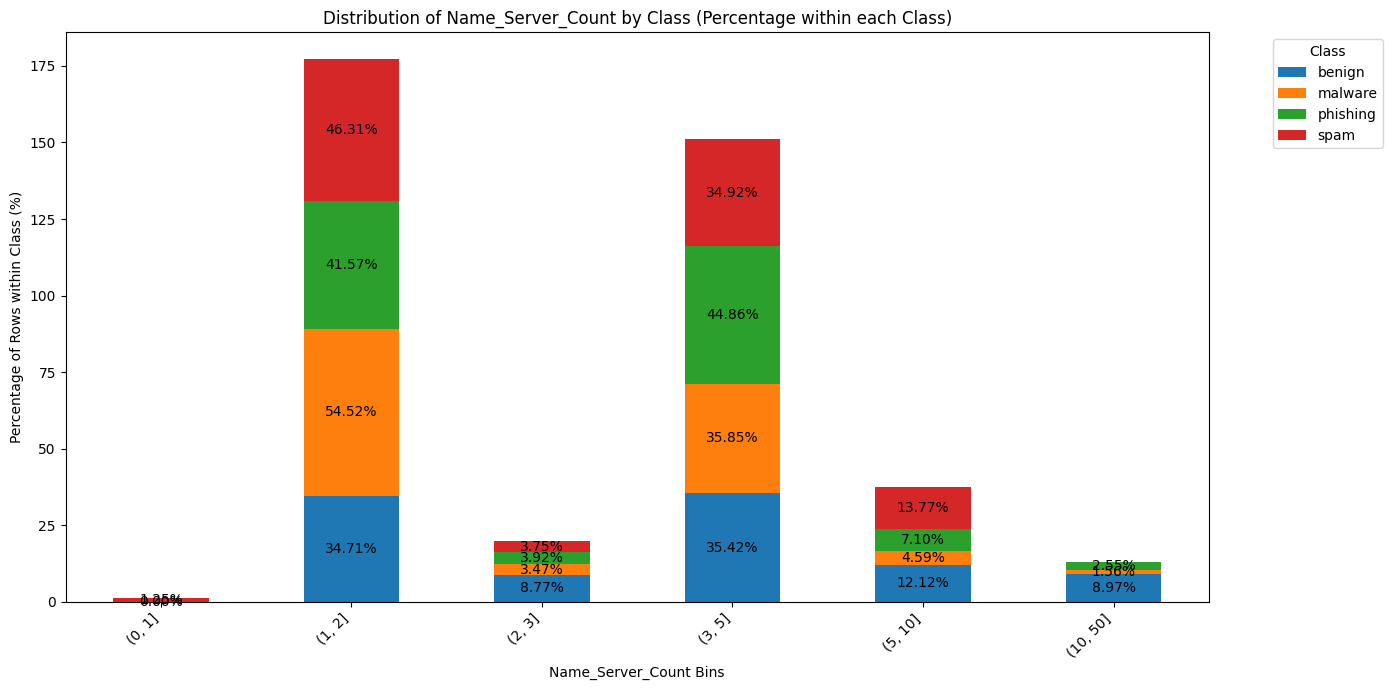

In [33]:
# Name_Server_Count: 
# filter out negative values
filtered_df = df_combined[df_combined['Name_Server_Count'] >= 0]
plot_feature_distribution(filtered_df, 'Name_Server_Count',
                          bins=[0, 1, 2, 3, 5, 10, 50, 100])

In [34]:
Name_Server_Count_stats_by_class = df.groupby('class')['Name_Server_Count'].describe()

# Display the result
print(Name_Server_Count_stats_by_class)

             count          mean           std  min  25%  50%  75%  \
class                                                                
benign    500001.0  1.844671e+13  1.304380e+16 -1.0  0.0  0.0  2.0   
malware     5001.0  2.524495e+00  3.102362e+00  0.0  0.0  2.0  4.0   
phishing    5001.0  3.027395e+00  4.340121e+00  0.0  0.0  2.0  4.0   
spam        4337.0  9.545769e-01  3.053945e+00  0.0  0.0  0.0  0.0   

                   max  
class                   
benign    9.223372e+18  
malware   4.600000e+01  
phishing  4.000000e+01  
spam      3.300000e+01  


`
Phishing prefers 3-5 name servers more than other malicious traffic
`

`
Benign traffic shows more balanced distribution between 1-2 and 3-5 servers
`

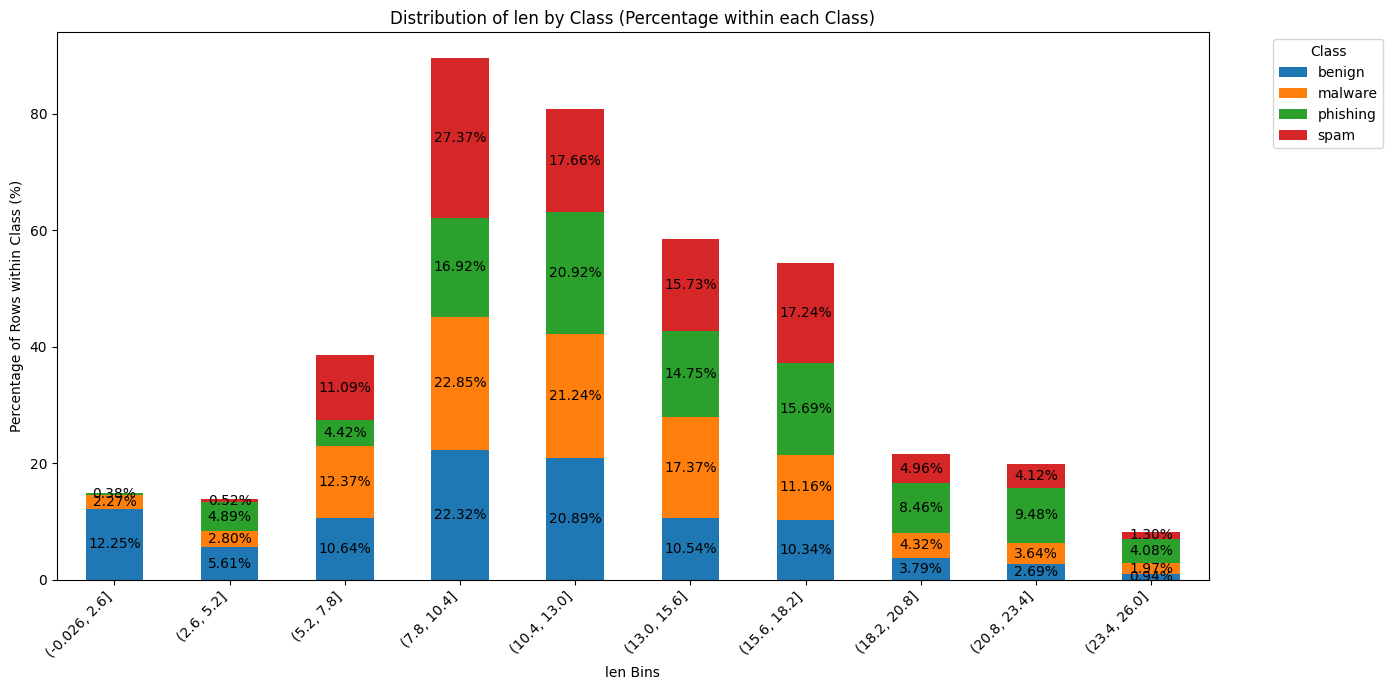

In [35]:
# len:
plot_feature_distribution(df_combined, 'len')

In [36]:
len_stats_by_class = df.groupby('class')['len'].describe()

# Display the result
print(len_stats_by_class)

             count           mean           std  min  25%   50%   75%  \
class                                                                   
benign    500001.0      10.539753  6.012596e+00  0.0  7.0  10.0  14.0   
malware     5001.0      12.744451  9.173237e+00  0.0  8.0  12.0  16.0   
phishing    5001.0  234122.234753  1.170212e+06 -1.0  0.0  13.0  21.0   
spam        4337.0      12.993313  4.979173e+00  5.0  9.0  12.0  16.0   

                 max  
class                 
benign          64.0  
malware        142.0  
phishing  10598022.0  
spam            32.0  



*Key findings:*
1. Benign: Mean ~10.54 chars, evenly distributed, highest presence in short ranges
2. Malware: Mean ~12.74 chars, slightly longer than benign, concentrated in mid-ranges
3. Phishing: Extreme variability (mean 234,122 chars due to outliers), higher presence in longer ranges
4. Spam: Mean ~12.99 chars, most concentrated distribution (5-32 chars)

*Overall:*
- Malicious domains tend to be slightly longer than benign
- Most domains across classes fall within 7-16 char range
- *Length patterns could aid in identifying suspicious domains, but should be used with other indicators*

<b>Categrical Features:</b> 

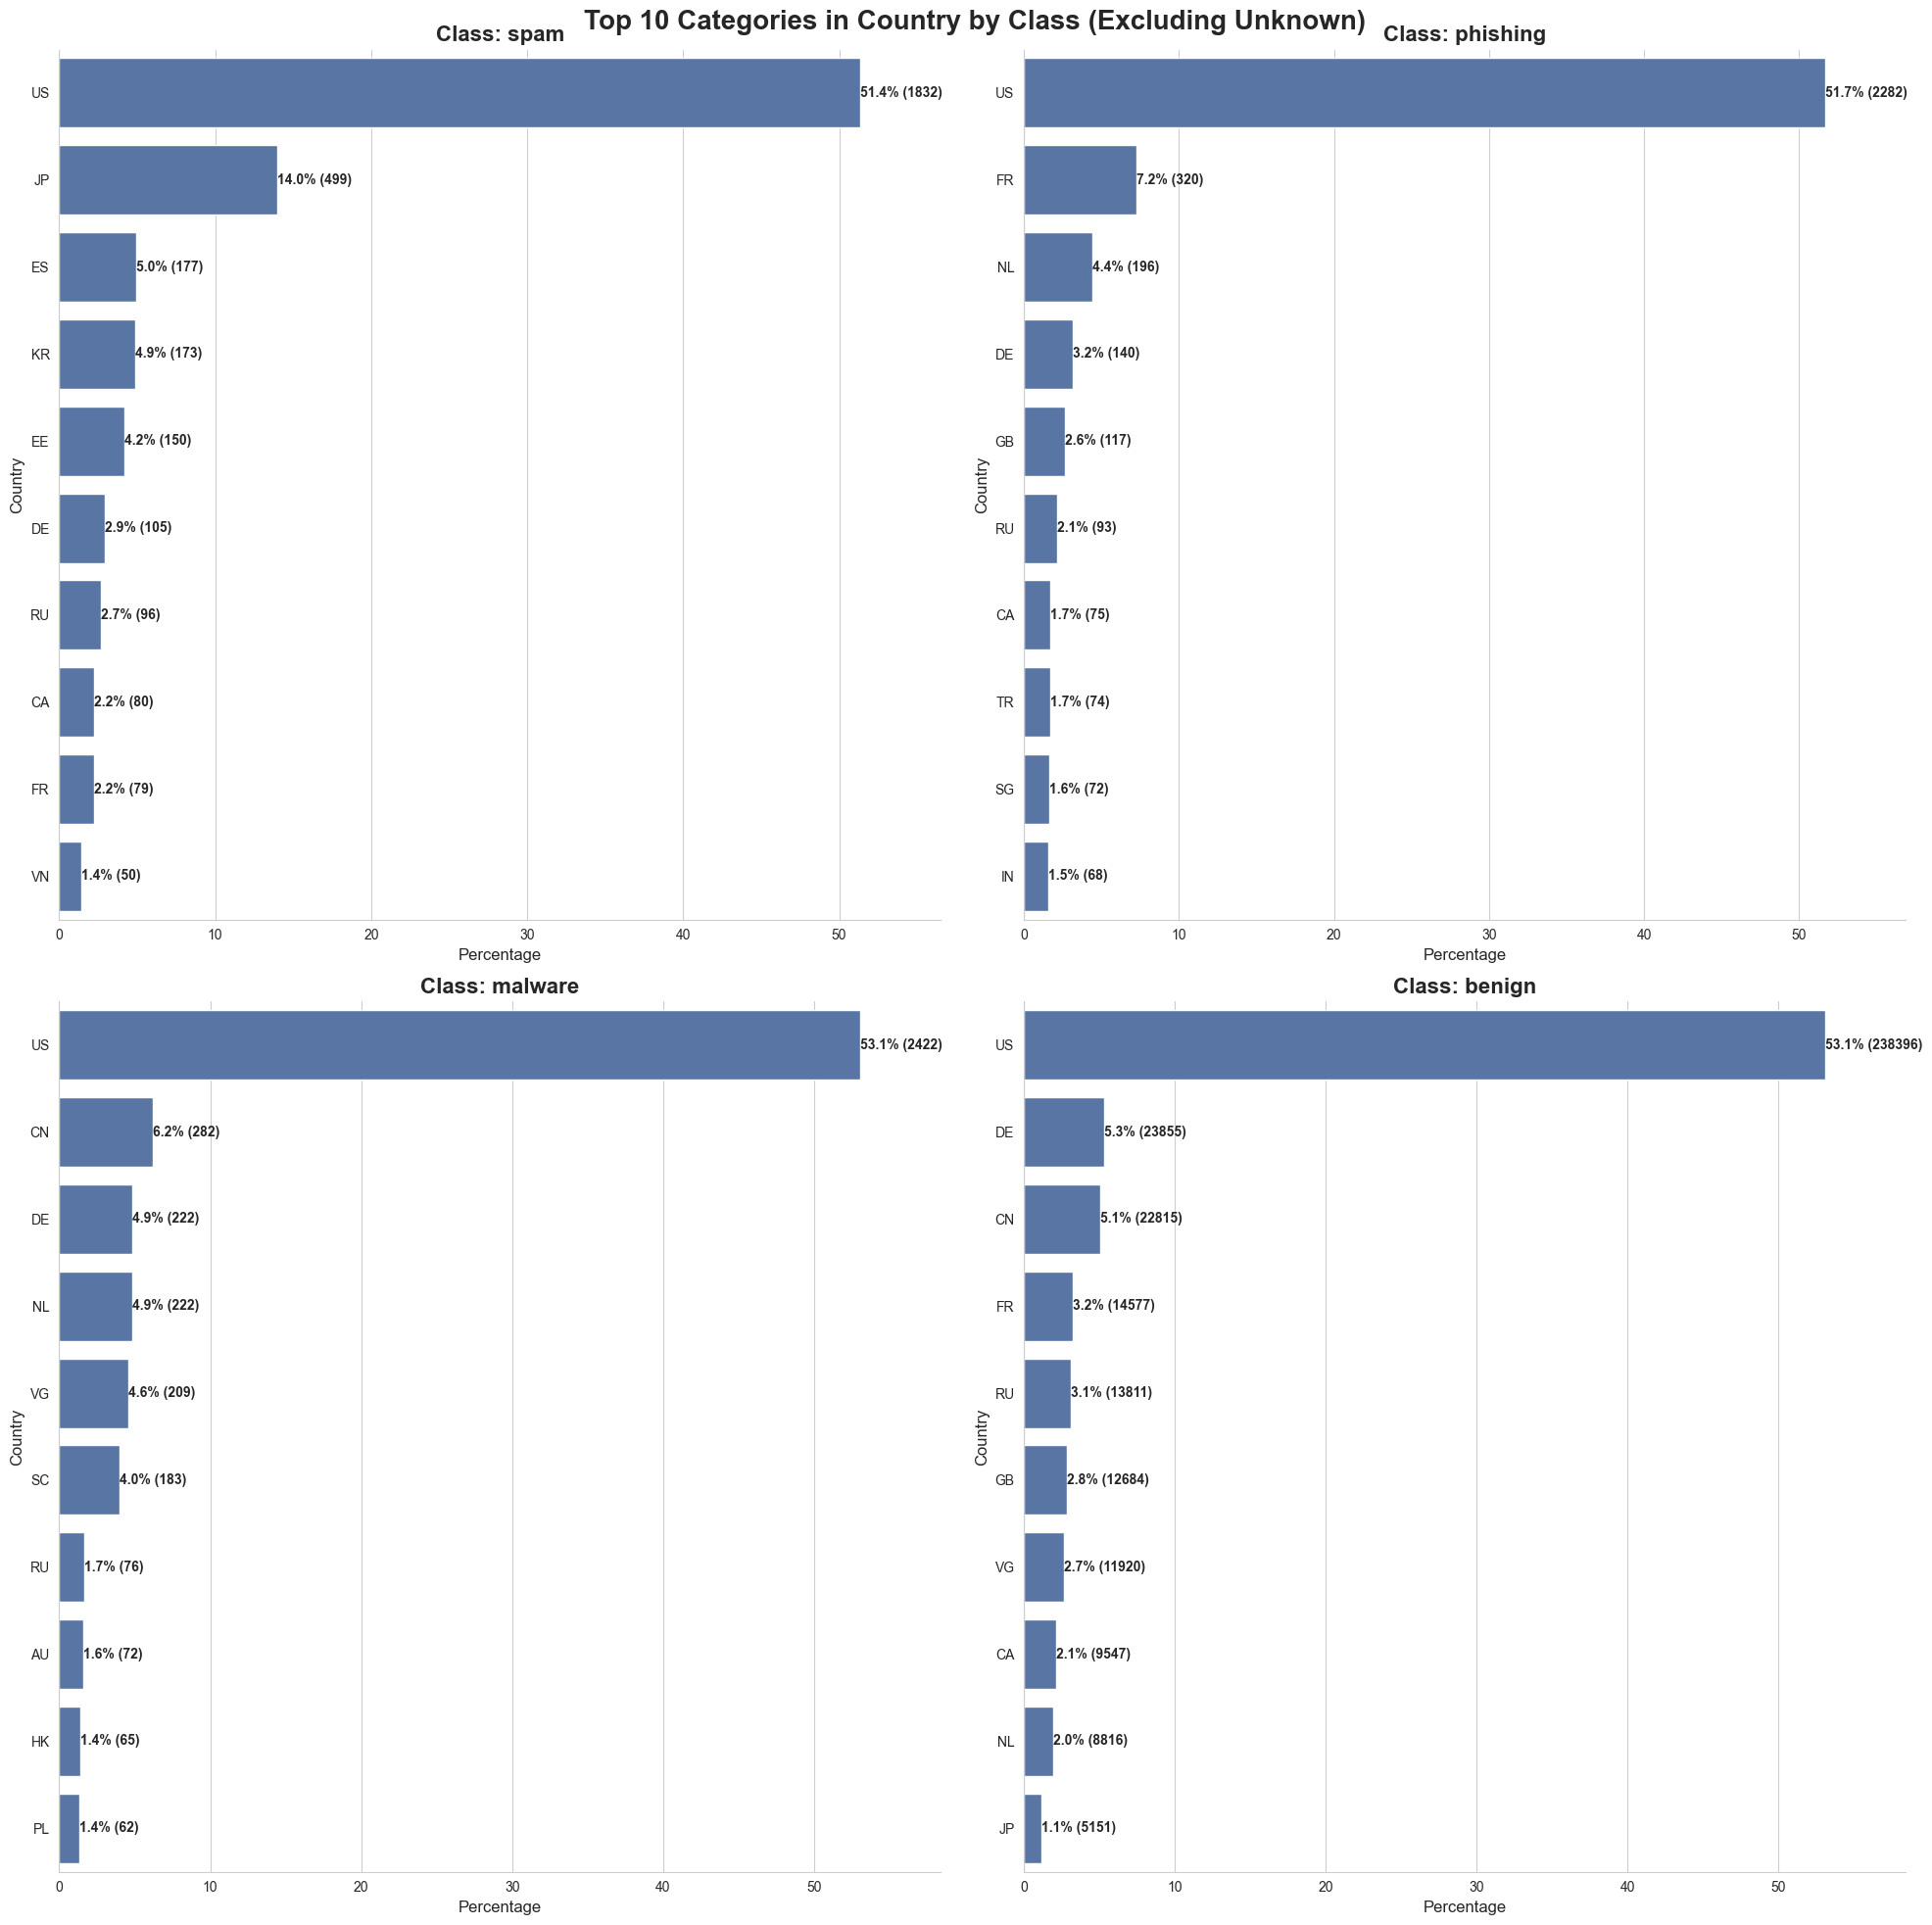

Analysis for Country (Excluding Unknown):

Class: spam
Total unique values: 26
Total samples after removing unknown: 3567
Top 5 categories:
US: 1832 (51.4%)
JP: 499 (14.0%)
ES: 177 (5.0%)
KR: 173 (4.9%)
EE: 150 (4.2%)


Analysis for Country (Excluding Unknown):

Class: spam
Total unique values: 26
Total samples after removing unknown: 3567
Top 5 categories:
US: 1832 (51.4%)
JP: 499 (14.0%)
ES: 177 (5.0%)
KR: 173 (4.9%)
EE: 150 (4.2%)

Class: phishing
Total unique values: 91
Total samples after removing unknown: 4416
Top 5 categories:
US: 2282 (51.7%)
FR: 320 (7.2%)
NL: 196 (4.4%)
DE: 140 (3.2%)
GB: 117 (2.6%)


Analysis for Country (Excluding Unknown):

Class: spam
Total unique values: 26
Total samples after removing unknown: 3567
Top 5 categories:
US: 1832 (51.4%)
JP: 499 (14.0%)
ES: 177 (5.0%)
KR: 173 (4.9%)
EE: 150 (4.2%)

Class: phishing
Total unique values: 91
Total samples after removing unknown: 4416
Top 5 categories:
US: 2282 (51.7%)
FR: 320 (7.2%)
NL: 196 (4.4%)
DE: 140 (3.2%)

In [37]:
# Country usage:
analyze_categorical_feature(df, 'Country')

*Key Findings*

- US dominates all categories (51-53%), making country alone insufficient for classification

*Distinctive Secondary Sources*
- Spam: Japan (14%)
- Phishing: France (7.2%), Netherlands (4.4%)
- Malware: China (6.2%), Virgin Islands (4.6%)

*Diversity*
- Most diverse: Benign (832 countries)
- Least diverse: Spam (26 countries)

*Unique Patterns*
- Spam: High Asian representation (Japan, South Korea)
- Phishing: Strong European presence
- Malware: Only category with Virgin Islands in top 5


*Secondary hotspots and diversity levels could provide valuable signals for traffic categorization*

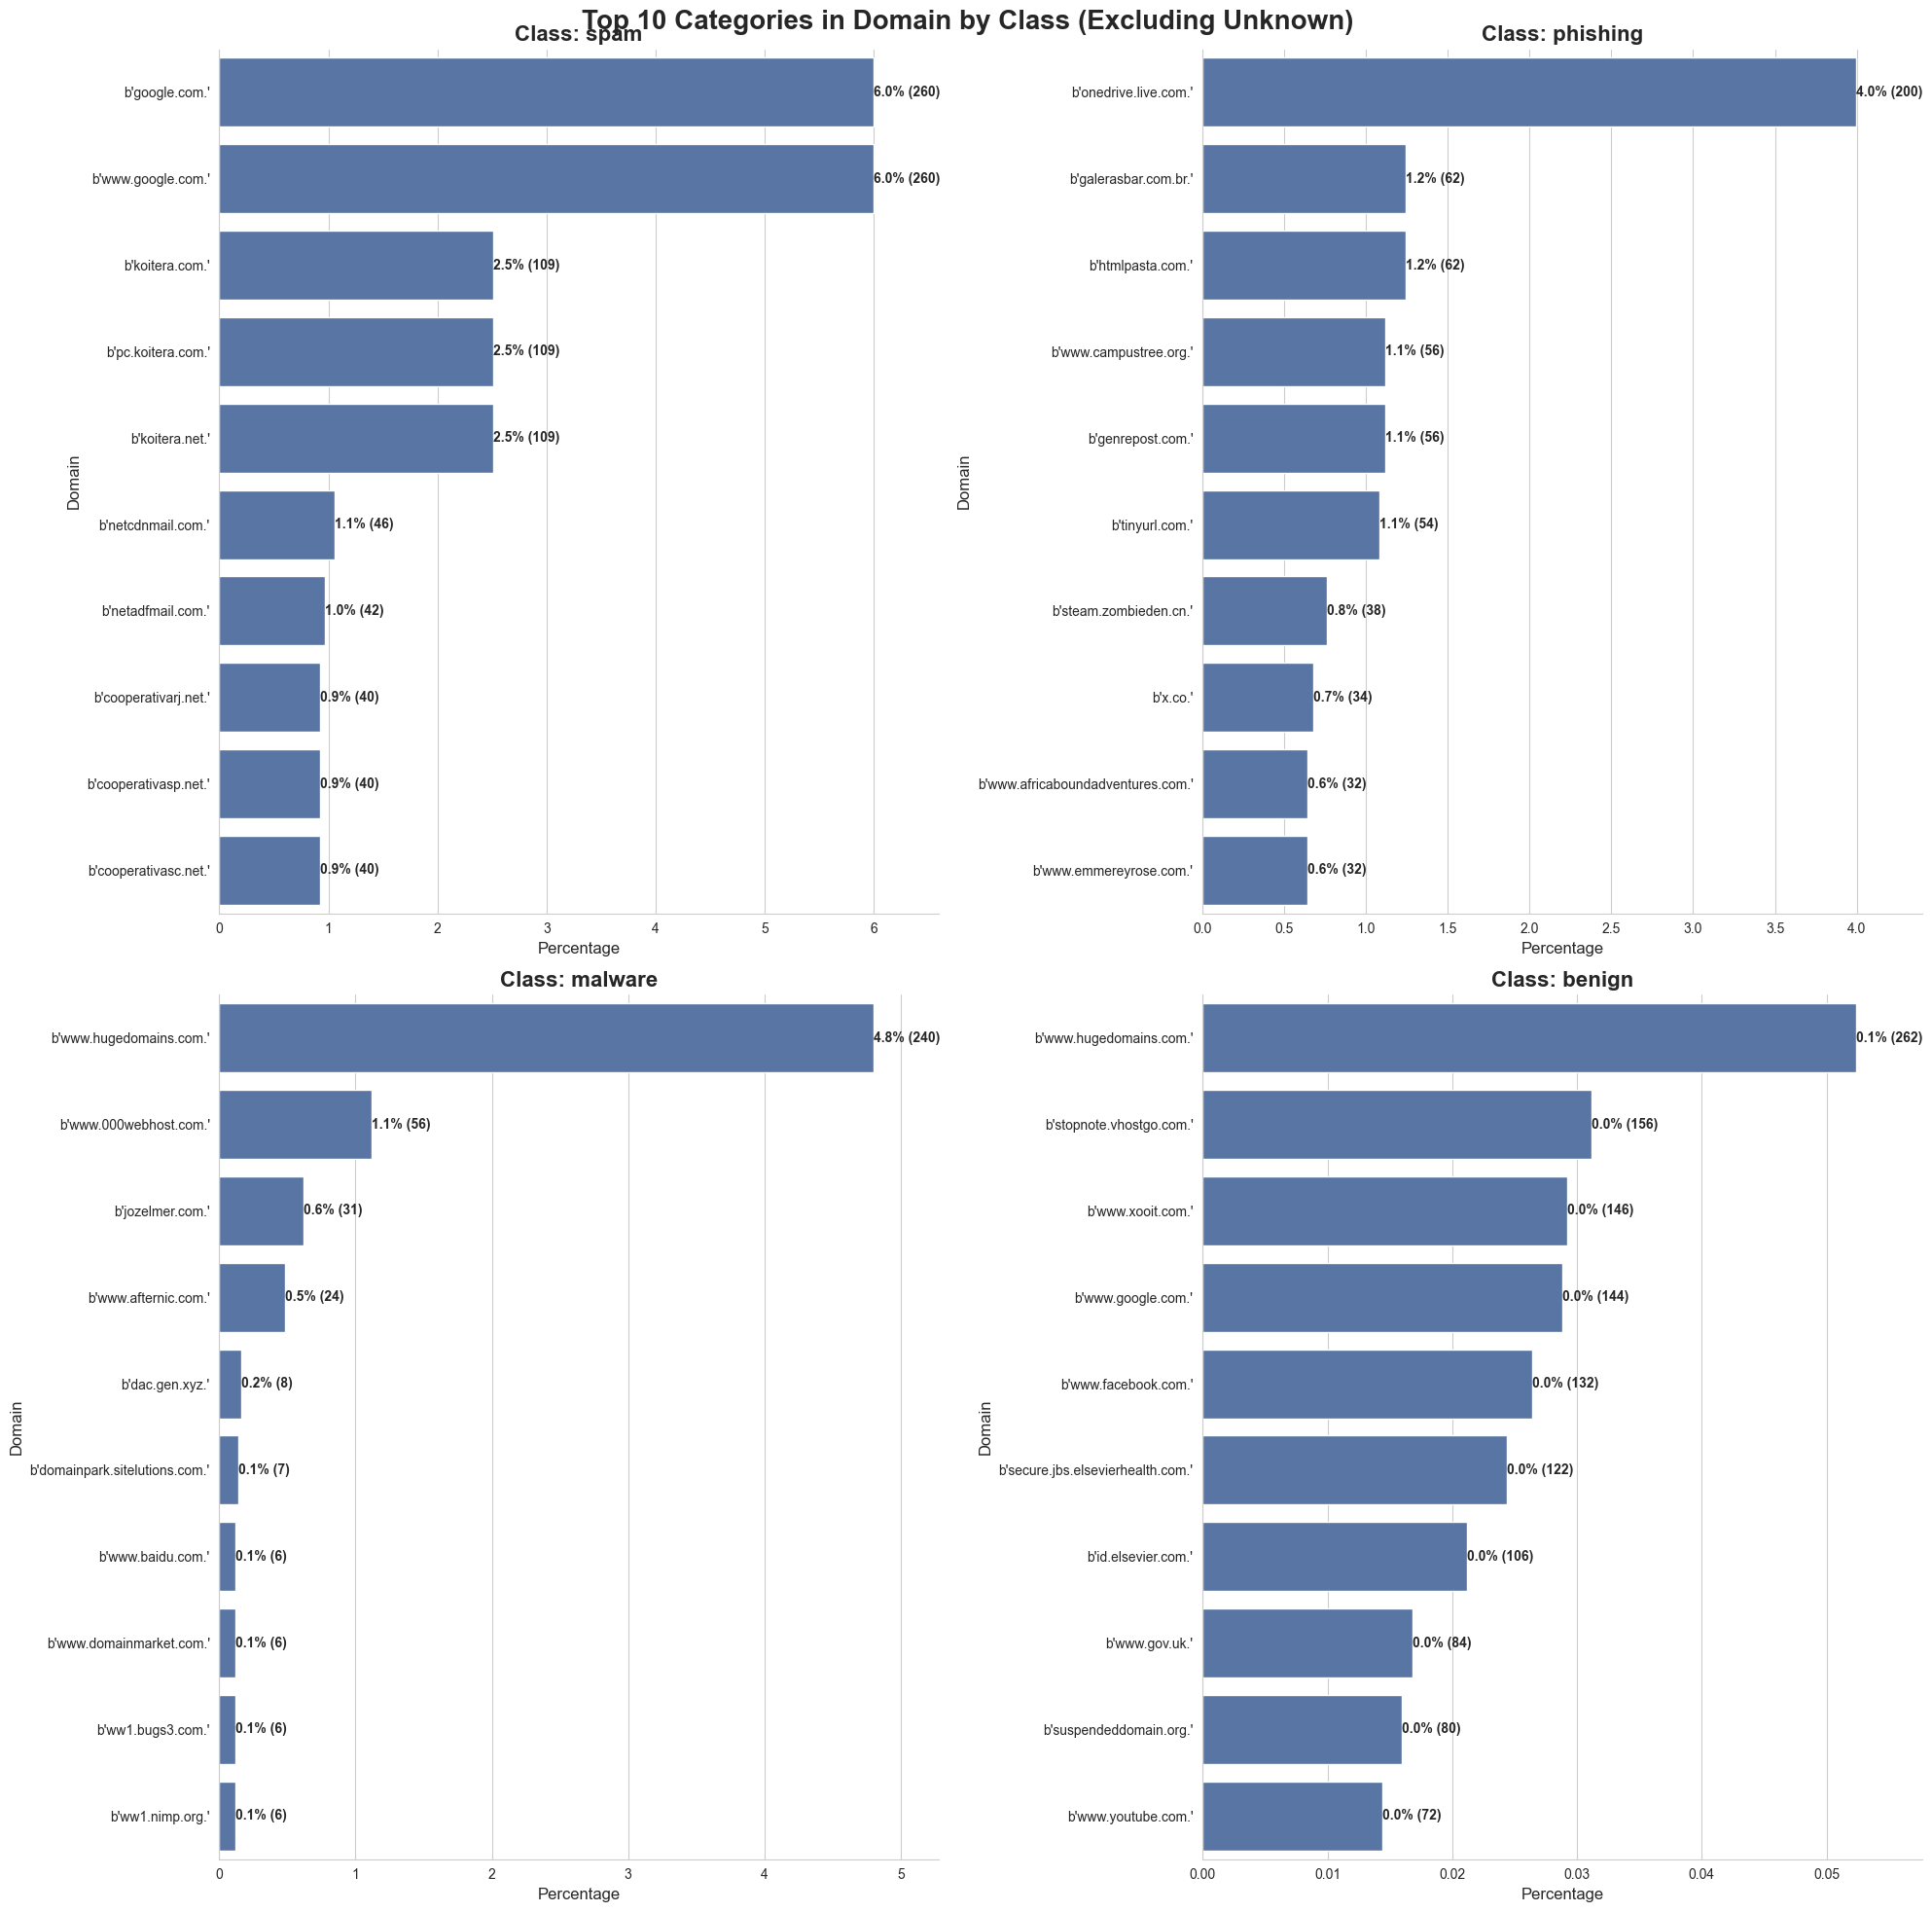

Analysis for Domain (Excluding Unknown):

Class: spam
Total unique values: 290
Total samples after removing unknown: 4337
Top 5 categories:
b'google.com.': 260 (6.0%)
b'www.google.com.': 260 (6.0%)
b'koitera.com.': 109 (2.5%)
b'pc.koitera.com.': 109 (2.5%)
b'koitera.net.': 109 (2.5%)


Analysis for Domain (Excluding Unknown):

Class: spam
Total unique values: 290
Total samples after removing unknown: 4337
Top 5 categories:
b'google.com.': 260 (6.0%)
b'www.google.com.': 260 (6.0%)
b'koitera.com.': 109 (2.5%)
b'pc.koitera.com.': 109 (2.5%)
b'koitera.net.': 109 (2.5%)

Class: phishing
Total unique values: 1648
Total samples after removing unknown: 5001
Top 5 categories:
b'onedrive.live.com.': 200 (4.0%)
b'galerasbar.com.br.': 62 (1.2%)
b'htmlpasta.com.': 62 (1.2%)
b'www.campustree.org.': 56 (1.1%)
b'genrepost.com.': 56 (1.1%)


Analysis for Domain (Excluding Unknown):

Class: spam
Total unique values: 290
Total samples after removing unknown: 4337
Top 5 categories:
b'google.com.': 260 (6.

In [38]:
# Domain usage:
analyze_categorical_feature(df, 'Domain')

*Domain Analysis: Key Insights*

*1. Diversity:*
   - Benign: Highest (312,998 unique)
   - Spam: Lowest (290 unique)

*2. Notable Patterns:*
   - Spam: 19.5% from top 5 domains (Google & Koitera)
   - Phishing: Uses legitimate-looking domains (e.g., onedrive.live.com)
   - Malware: Prominent use of hosting services (HugeDomains, 000webhost)

*3. Key Differentiator:*
   Benign traffic shows no domain concentration (all <0.1%)

*Conclusion:* Domain patterns <b>strongly indicate traffic category</b>, especially for identifying malicious activities.

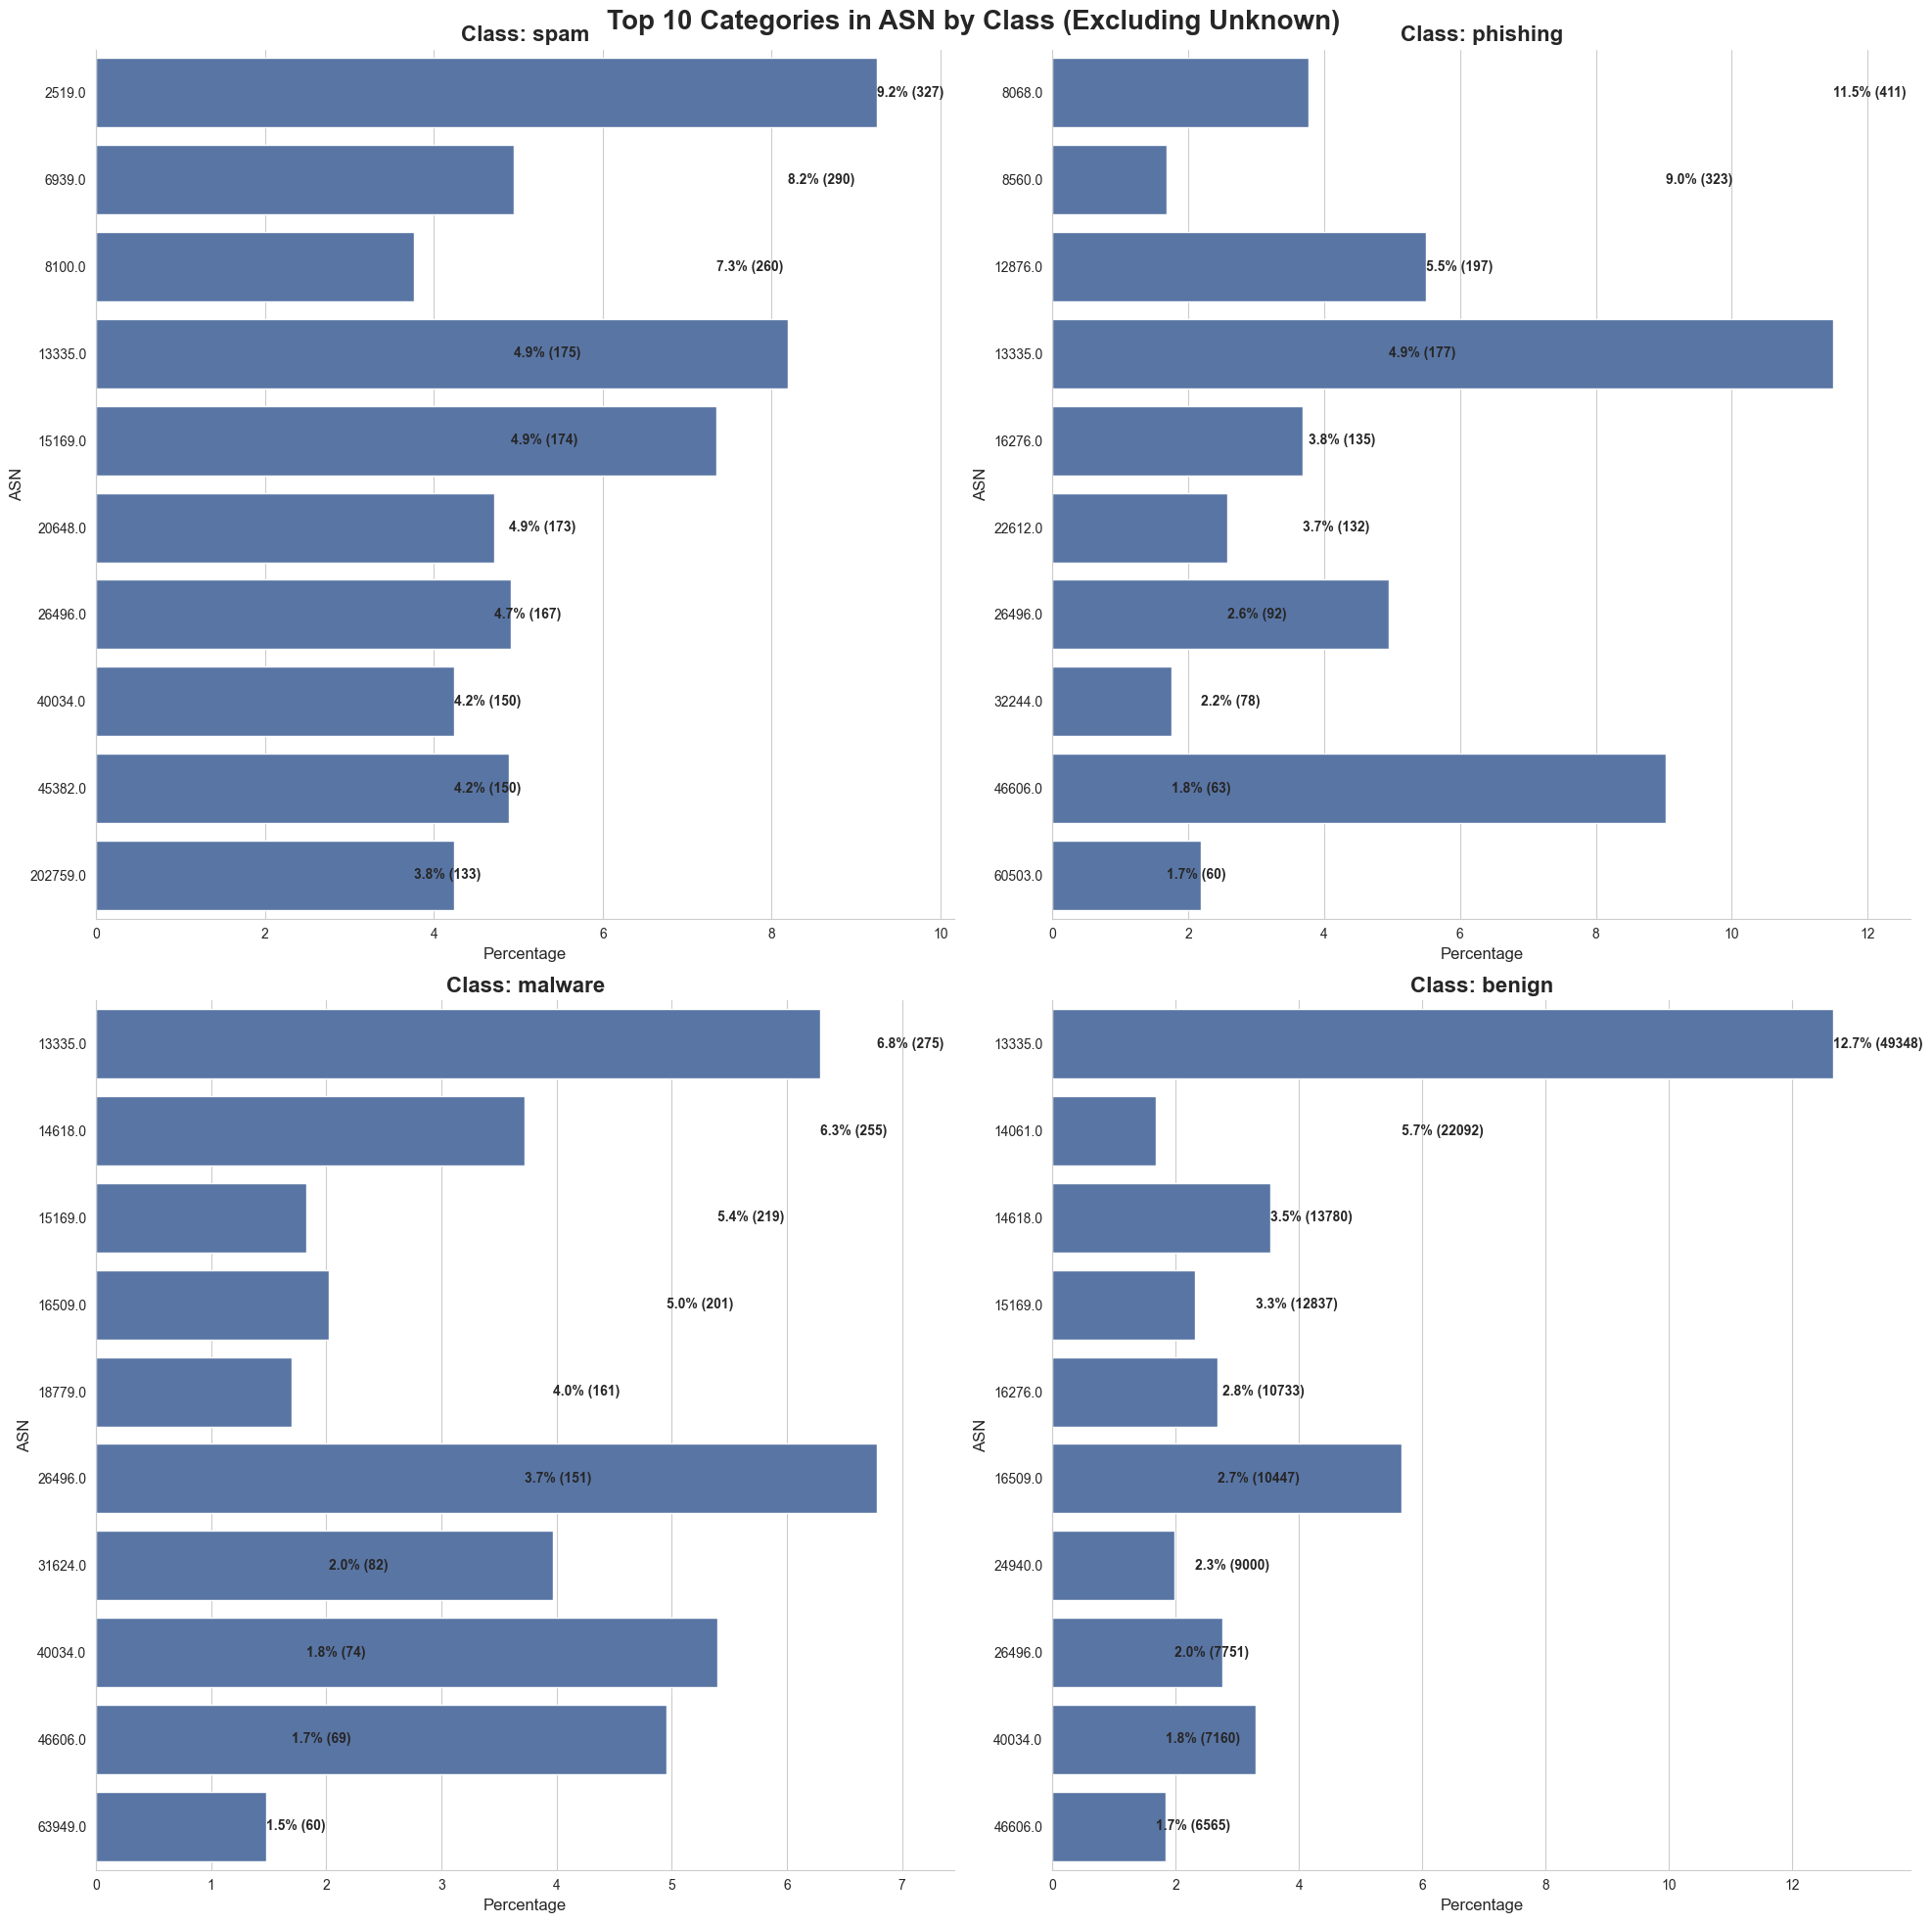

Analysis for ASN (Excluding Unknown):

Class: spam
Total unique values: 74
Total samples after removing unknown: 3538
Top 5 categories:
2519.0: 327 (9.2%)
13335.0: 290 (8.2%)
15169.0: 260 (7.3%)
6939.0: 175 (4.9%)
26496.0: 174 (4.9%)


Analysis for ASN (Excluding Unknown):

Class: spam
Total unique values: 74
Total samples after removing unknown: 3538
Top 5 categories:
2519.0: 327 (9.2%)
13335.0: 290 (8.2%)
15169.0: 260 (7.3%)
6939.0: 175 (4.9%)
26496.0: 174 (4.9%)

Class: phishing
Total unique values: 342
Total samples after removing unknown: 3578
Top 5 categories:
13335.0: 411 (11.5%)
46606.0: 323 (9.0%)
12876.0: 197 (5.5%)
26496.0: 177 (4.9%)
8068.0: 135 (3.8%)


Analysis for ASN (Excluding Unknown):

Class: spam
Total unique values: 74
Total samples after removing unknown: 3538
Top 5 categories:
2519.0: 327 (9.2%)
13335.0: 290 (8.2%)
15169.0: 260 (7.3%)
6939.0: 175 (4.9%)
26496.0: 174 (4.9%)

Class: phishing
Total unique values: 342
Total samples after removing unknown: 3578
Top 5 

In [39]:
# ASN usage:
analyze_categorical_feature(df, 'ASN')

*1. Diversity:*
   - Benign: Highest (10,381 unique ASNs)
   - Spam: Lowest (74 unique ASNs)

*2. Common ASNs across categories:*
   - 13335.0: Top 5 in all categories (Cloudflare)
   - 26496.0: Present in top 5 of all categories (GoDaddy)

*3. Distinctive patterns:*
   - Spam: High concentration in top ASNs (34.5% in top 5)
   - Phishing: Strong presence of 46606.0 (9%, not top 5 in others)
   - Malware: More evenly distributed among top ASNs

*4. Benign traffic:*
   - More diverse, but still shows concentration in top ASNs

*Conclusion:* ASN patterns provide valuable signals for traffic categorization, with spam showing the most distinct distribution.

### Section 6.2: Bivariate Analysis

`Bivariate analysis involves the analysis of two variables to understand the relationship between them.`

##### 1. Correlation Matrix for Numerical Features 

In [40]:
# apply frequency encoding to all categorical features except 'class' which will bee one-hot encoded
df = frequency_encode(df, exclude_columns=['class'])

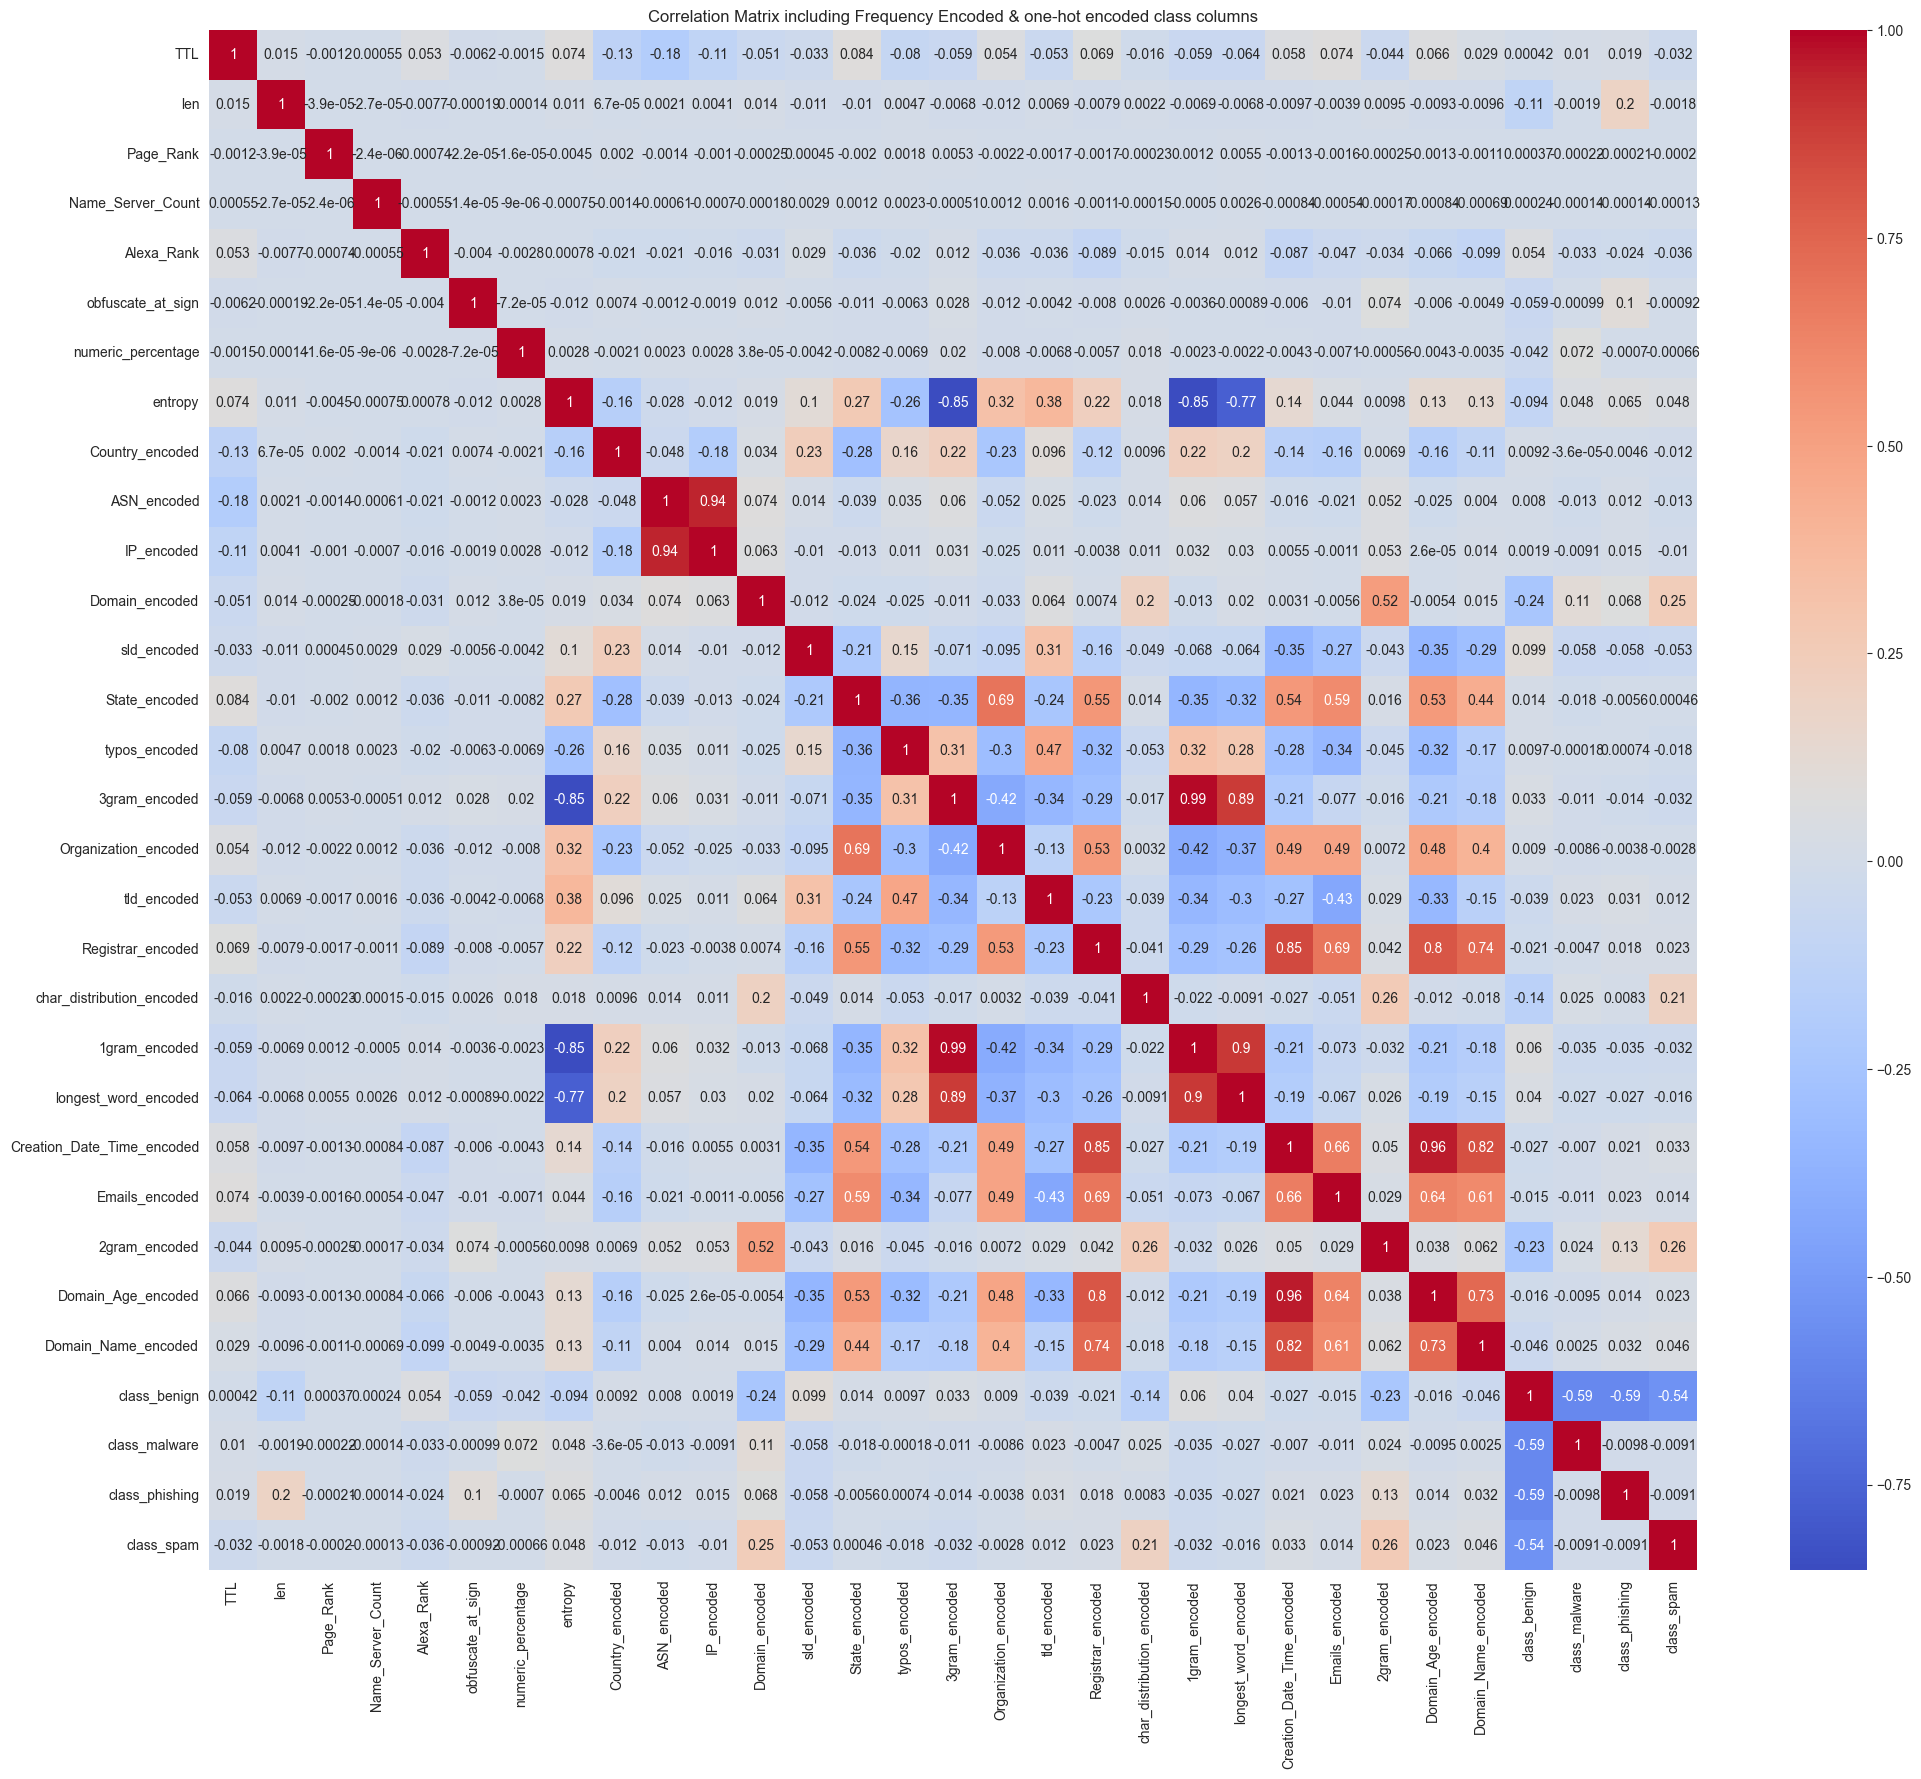

In [44]:
# init OneHotEncoder with the correct parameter
encoder = OneHotEncoder(sparse_output=False, drop=None)

# fit and transform the class column
encoded_class = encoder.fit_transform(df[['class']])

# create a df with the one-hot encoded columns
encoded_df = pd.DataFrame(encoded_class, columns=encoder.get_feature_names_out(['class']))

# combine the one-hot encoded class columns with the frequency encoded columns
df_onehot = pd.concat([df.drop(columns=['class']), encoded_df], axis=1)

#  only numerical features 
numerical_df = df_onehot.select_dtypes(include=['float64', 'int64'])

# Drop the specified features - didn't work on parsing
columns_to_drop = ['dec_8', 'hex_8', 'hex_32', 'oc_32', 'oc_8']
numerical_df = numerical_df.drop(columns=columns_to_drop, errors='ignore')

# ca;culation of the correlation matrix
correlation_matrix = numerical_df.corr()

# plot the heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix including Frequency Encoded & one-hot encoded class columns')
plt.show()

In [42]:
threshold = 0.5 # pearson Correlation Coefficient thereshold for strong correlation

#  correlations that are above the threshold or below the negative threshold
strong_correlations = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]

# drop diagonal correlations (which are all 1s by definition)
strong_correlations = strong_correlations.where(np.triu(np.ones(strong_correlations.shape), k=1).astype(bool))

# print the strong correlations
print(f"Strong Correlations (>|{threshold}|):")
print(strong_correlations.dropna(how='all', axis=0).dropna(how='all', axis=1))

Strong Correlations (>|0.5|):
                            IP_encoded  3gram_encoded  Organization_encoded  \
entropy                            NaN      -0.848683                   NaN   
ASN_encoded                   0.942471            NaN                   NaN   
Domain_encoded                     NaN            NaN                   NaN   
State_encoded                      NaN            NaN              0.689729   
3gram_encoded                      NaN            NaN                   NaN   
Organization_encoded               NaN            NaN                   NaN   
Registrar_encoded                  NaN            NaN                   NaN   
1gram_encoded                      NaN            NaN                   NaN   
Creation_Date_Time_encoded         NaN            NaN                   NaN   
Emails_encoded                     NaN            NaN                   NaN   
Domain_Age_encoded                 NaN            NaN                   NaN   
class_benign          


- **IP and ASN**: The correlation between `ASN_encoded` and `IP_encoded` is inflated because an ASN represents a group of IPs. Multiple IPs mapping to the same ASN does not indicate a meaningful, independent relationship.
- **Entropy and n-grams**: The negative correlation between entropy and n-grams (e.g., `3gram_encoded`) arises from the mathematical nature of these features, where higher n-gram counts reduce randomness. This is a mathematical artifact, not a meaningful interaction.


### Section 6.3: Multivariate Analysis

	•	Pair plots, cluster analysis, or any relevant multivariate technique.

	•	Section 7.1: Create new features if needed.
	•	Section 7.2: Feature selection based on initial insights.
	•	Section 7.3: Handling categorical variables (encoding techniques).

## 7. Insights and Conclusions

	•	Summarize the key findings from the EDA.
	•	Discuss any patterns, correlations, or trends that were uncovered.
	•	Outline potential next steps (e.g., further analysis, modeling).